This file is the successor of 'Ite_threshold_analysis_combined_ite_100k'

The following points were added since then:

- the dataset contains now all space entries from the typing study
- more accurate calculation of the thresholds for autocorrection and prediction
- we added a feature to the Gauss-estimation where we show the thresholds in the plot and the amount of overlapping between our classifciations of autocorrections and predictions
- Because the resulting, larger dataset needs more horsepower for preprocessing calculations than jupyter notebook or a single PC without GPUs can offer, we created the file 'Prepare_files_for_analysis_ite_thresholds.py' which 'outsources' the preprocessing (in my case I used the ETH cluster for these kind of calculations) 

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import math
#from scipy.stats import norm
from sklearn import mixture
import scipy.stats as stats

In [39]:
log_comb_ite_with_participants = pd.read_csv('log_comb_ite_with_participants_with_user_groups_complete.csv', dtype={'user type': np.unicode_})

In [40]:
log_comb_ite_with_participants = log_comb_ite_with_participants.drop(['Unnamed: 0'],axis=1)
log_comb_ite_with_participants = log_comb_ite_with_participants.dropna()

In [4]:
log_combined_ite_1 = pd.read_csv('log_processed_autocorr_and_predict_combined.csv')

In [41]:
log_combined_ite = log_combined_ite_1.loc[log_combined_ite_1['ite'] == 'autocorr_or_predict']

In [42]:
log_combined_ite = log_combined_ite.drop(['ite2'], axis = 1)
log_combined_ite = log_combined_ite.dropna()

In [43]:
log_comb_ite_with_participants_spaces = log_comb_ite_with_participants.loc[log_comb_ite_with_participants['ite_prev'] == 'none']
log_comb_ite_with_participants_spaces = log_comb_ite_with_participants_spaces.dropna()
log_comb_ite_with_participants_ites = log_comb_ite_with_participants.loc[log_comb_ite_with_participants['ite_prev'] != 'none']
log_comb_ite_with_participants_ites = log_comb_ite_with_participants_ites.dropna()

In [44]:
# Ignore user performance group typing 0 to 2.5 wpm 
log_comb_ite_with_participants_ites = log_comb_ite_with_participants_ites[log_comb_ite_with_participants_ites['user type 5'] != 0]

In [55]:
outliers = 0
# remove certain outliers depending on performance group
for row in log_comb_ite_with_participants_ites.index:
    performance = log_comb_ite_with_participants_ites.loc[row,'user type 5']
    iki = log_comb_ite_with_participants_ites.loc[row,'iki']
    if performance == 5 and iki >= 1875 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 10 and iki >= 2125 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 15 and iki >= 1875 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 20 and iki >= 1750 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 25 and iki >= 1500 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 30 and iki >= 1500 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 35 and iki >= 1750 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 40 and iki >= 1750 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 45 and iki >= 1750 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 50 and iki >= 1500 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 55 and iki >= 1250 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 60 and iki >= 1250 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
    if performance == 65 and iki >= 1000 :
        log_comb_ite_with_participants_ites.loc[row,'iki'] = np.nan
        outliers = outliers + 1
log_comb_ite_with_participants_ites = log_comb_ite_with_participants_ites.dropna()
print(outliers)

2977


In [56]:
# -*- coding: utf-8 -*-

# Class
class PrintTable:
    def __init__(self, values, captions, widths, aligns):
        if not all([len(values[0]) == len(x) for x in [captions, widths, aligns]]):
            raise Exception()
        self._tablewidth = sum(widths) + 3*(len(captions)-1) + 4
        self._values = values
        self._captions = captions
        self._widths = widths
        self._aligns = aligns

    def print(self):
        self._printTable()

    def _printTable(self):
        formattext_head = ""
        formattext_cell = ""
        for i,v in enumerate(self._widths):
            formattext_head += "{" + str(i) + ":<" + str(v) + "} | "
            formattext_cell += "{" + str(i) + ":" + self._aligns[i] + str(v) + "} | "
        formattext_head = formattext_head[:-3]
        formattext_head = "  " + formattext_head.strip() + "  "
        formattext_cell = formattext_cell[:-3]
        formattext_cell = "  " + formattext_cell.strip() + "  "

        print("-"*self._tablewidth)
        print(formattext_head.format(*self._captions))
        print("-"*self._tablewidth)
        for w in self._values:
            print(formattext_cell.format(*w))
        print("-"*self._tablewidth)

In [57]:
def Apply_Gaussian_mixture_models_2(dataFrame,n_components,x_lim=1300,compare_gmm_to_kde = 0):
    headername = ["Gaussians","Mean","Sigma","Left 90%", "Right 90%", "Left 85%" , "Right 85%"]
    data = [["no {}".format(x+1), x, x*2,x**3,x**4,x**5,x**6] for x in range(n_components)]
    
    #x1 = dataFrame.to_numpy()
    x1 = dataFrame.values
    
    # Remove datapoints where iki < 20 ms
    for i in range(len(x1)):
        if x1[i] <= 20:
            x1[i] = np.nan
    x1 = x1[~np.isnan(x1)]
    
    # Calculating percentages of outliers upon a certain threshold
    
    outliers_500 = 0
    outliers_750 = 0
    outliers_1000 = 0
    outliers_1250 = 0
    outliers_1500 = 0
    outliers_1750 = 0
    outliers_1875 = 0
    outliers_2000 = 0
    outliers_2125 = 0
    outliers_2250 = 0
    outliers_2500 = 0
    outliers_4500 = 0
    outliers_4000 = 0
    outliers_3500 = 0
    outliers_3000 = 0
    total_count = len(x1)
    
    # count outliers:
    for i in range(len(x1)):
        if x1[i] >= 500:
            outliers_500 = outliers_500 + 1
        if x1[i] >= 750:
            outliers_750 = outliers_750 + 1
        if x1[i] >= 1000:
            outliers_1000 = outliers_1000 + 1
        if x1[i] >= 1250:
            outliers_1250 = outliers_1250 + 1
        if x1[i] >= 1500:
            outliers_1500 = outliers_1500 + 1
        if x1[i] >= 1750:
            outliers_1750 = outliers_1750 + 1
        if x1[i] >= 1875:
            outliers_1875 = outliers_1875 + 1
        if x1[i] >= 2000:
            outliers_2000 = outliers_2000 + 1
        if x1[i] >= 2125:
            outliers_2125 = outliers_2125 + 1
        if x1[i] >= 2250:
            outliers_2250 = outliers_2250 + 1
        if x1[i] >= 2500:
            outliers_2500 = outliers_2500 + 1
        if x1[i] >= 3000:
            outliers_3000 = outliers_3000 + 1
        if x1[i] >= 3500:
            outliers_3500 = outliers_3500 + 1
        if x1[i] >= 4000:
            outliers_4000 = outliers_4000 + 1
        if x1[i] >= 4500:
            outliers_4500 = outliers_4500 + 1
    
    #print percentages:
    print('Percentage of outliers above 500 ms: ' + str(outliers_500/total_count))
    print('Percentage of outliers above 750 ms: ' + str(outliers_750/total_count))
    print('Percentage of outliers above 1000 ms: ' + str(outliers_1000/total_count))
    print('Percentage of outliers above 1250 ms: ' + str(outliers_1250/total_count))
    print('Percentage of outliers above 1500 ms: ' + str(outliers_1500/total_count))
    print('Percentage of outliers above 1750 ms: ' + str(outliers_1750/total_count))
    print('Percentage of outliers above 1875 ms: ' + str(outliers_1875/total_count))
    print('Percentage of outliers above 2000 ms: ' + str(outliers_2000/total_count))
    print('Percentage of outliers above 2125 ms: ' + str(outliers_2125/total_count))
    print('Percentage of outliers above 2250 ms: ' + str(outliers_2250/total_count))
    print('Percentage of outliers above 2500 ms: ' + str(outliers_2500/total_count))
    print('Percentage of outliers above 3000 ms: ' + str(outliers_3000/total_count))
    print('Percentage of outliers above 3500 ms: ' + str(outliers_3500/total_count))
    print('Percentage of outliers above 4000 ms: ' + str(outliers_4000/total_count))
    print('Percentage of outliers above 4500 ms: ' + str(outliers_4500/total_count))

    
    x2 = x1.reshape(-1,1)
    clf = mixture.GaussianMixture(n_components=n_components, covariance_type='full', max_iter=2000, n_init=10).fit(x2)
    xpdf = np.linspace(0,x_lim,2000)
    xpdf2 = xpdf.reshape(-1,1)
    density=np.exp(clf.score_samples(xpdf2))
    
    # prediction
    df_data = clf.predict_proba(xpdf2)
    df_prob = pd.DataFrame(data=df_data,columns=['Probability gaussian {}'.format(x+1) for x in range(n_components)])
    plt.subplots(1,figsize=(25,12))
    plt.xlim(0,x_lim)
    plt.xticks(range(0,x_lim,100))
    for i in range(n_components):
        df_tmp = df_prob[str('Probability gaussian ' + str(i+1))].to_numpy()
        df_tmp2 = df_prob[str('Probability gaussian ' + str(i+1))].to_numpy()
        plt.plot(xpdf2,df_tmp)
        for j in range(len(df_tmp2)-1):
            if(df_tmp[j] > 0.85):    
                if df_tmp[j+1] <= 0.85 :
                    print("85: " + str(x_lim*(j/len(df_tmp2))))
            if(df_tmp[j] < 0.85):
                if df_tmp[j+1] >= 0.85 :
                    print("85: " + str(x_lim*(j/len(df_tmp2))))
                if j < 200 and df_tmp[j+1] >= df_tmp[j]:
                    df_tmp2[j] = df_tmp2[j]
                else:
                    df_tmp2[j] = 0
            if(df_tmp[j] > 0.90):    
                if df_tmp[j+1] <= 0.90 :
                    print("90: " + str(x_lim*(j/len(df_tmp2))))
            if(df_tmp[j] < 0.90):
                if df_tmp[j+1] >= 0.90 :
                    print("90: " + str(x_lim*(j/len(df_tmp2))))
        plt.fill_between(xpdf,df_tmp2,alpha=0.2)
    
    if compare_gmm_to_kde == 1:
        fig, axs = plt.subplots(3,figsize=(25,24))
        axs[0].set_xlim(0,x_lim)
        axs[0].set_xticks(range(0,x_lim,100))
        axs[0].hist(x1,700,density=True,alpha=0.4)
        axs[0].plot(xpdf,density,'-r')
    else:
        fig, axs = plt.subplots(1,figsize=(25,12))
        axs.set_xlim(0,x_lim)
        axs.set_xticks(range(0,x_lim,100))
        axs.hist(x1,700,density=True,alpha=0.4)
        axs.plot(xpdf,density,'-r')


    for i in range(clf.n_components):
        pdf = clf.weights_[i] * stats.norm(clf.means_[i,0],np.sqrt(clf.covariances_[i,0])).pdf(xpdf)
        if compare_gmm_to_kde == 1:
            axs[0].fill_between(xpdf,pdf,facecolor='darkblue',edgecolor='none',alpha=0.4)
        else:
            axs.fill_between(xpdf,pdf,facecolor='darkblue',edgecolor='none',alpha=0.4)
        data[i][1] = int(clf.means_[i,0])
        data[i][2] = int(np.sqrt(clf.covariances_[i,0]))
        data[i][3] = int(clf.means_[i,0] - 1.65*np.sqrt(clf.covariances_[i,0]))
        data[i][4] = int(clf.means_[i,0] + 1.65*np.sqrt(clf.covariances_[i,0]))
        data[i][5] = int(clf.means_[i,0] - 1.44*np.sqrt(clf.covariances_[i,0]))
        data[i][6] = int(clf.means_[i,0] + 1.44*np.sqrt(clf.covariances_[i,0]))
    
    if compare_gmm_to_kde == 1:
        axs[1].set_xlim(0,x_lim)
        axs[1].set_xticks(range(0,x_lim,500))
        axs[1].hist(x1,700,density=True,alpha=0.3)
        sns.kdeplot(x1, shade=True,kernel='gau',gridsize=2000,alpha=0.8,ax=axs[1],color='darkorange')
        
        axs[2].set_xlim(0,x_lim)
        axs[2].set_xticks(range(0,x_lim,500))
        sns.kdeplot(x1, shade=True,kernel='gau',gridsize=2000,alpha=0.8,ax=axs[2],color='darkorange')
        axs[2].plot(xpdf,density,'-r')
    
    #PrintTable(data,headername,[10, 10, 10 ,10, 10, 10, 10],["<",">",">",">",">",">",">"]).print()

In [77]:
def Analyze_user_group(dataFrame):
    headername = ["User Group","Sample Size","% Autocorr","% Predict","% Undef.","Threshold Min", "Threshold Max"]
    data = [["{} WPM".format((x+1)*5),0,0,0,0,0,0] for x in range(21)]
    
    thresholds_predict = [345,354,556,438,408,376,380,356,351,339,327,315,297,297,290,288,253,274,300,300]
    thresholds_autocorr = [253,268,419,276,300,281,293,279,278,272,263,252,236,236,233,235,205,228,200,200]
    
    for i in range(20):
        data[i][5] = thresholds_autocorr[i]
        data[i][6] = thresholds_predict[i]
    
    sample_sizes = np.zeros(20)
    predict_percentages = np.zeros(20)
    autocorr_percentages = np.zeros(20)
    
    # Get Sample Size
    for i in range(19):
        data[i][1] = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5].shape[0] 
        sample_sizes[i] = data[i][1]
    data[19][1] = dataFrame.loc[dataFrame['user type 5'] == 99].shape[0]
    sample_sizes[19] = data[19][1]
    
    # Get percentage of autocorrections
    for i in range(19):
        df_autocorr_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][2] = round((df_autocorr_i.loc[df_autocorr_i['iki'] <= thresholds_autocorr[i]].shape[0])/(data[i][1]) * 100,3)
        autocorr_percentages[i] = data[i][2]
    df_autocorr_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][2] = round((df_autocorr_19.loc[df_autocorr_19['iki'] <= thresholds_autocorr[19]].shape[0])/(data[19][1]) * 100,3) 
    autocorr_percentages[19] = data[19][2]
    
    # Get percentage of predictions
    for i in range(19):
        df_predict_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][3] = round((df_predict_i.loc[df_predict_i['iki'] >= thresholds_predict[i]].shape[0])/(data[i][1])* 100,3)
        predict_percentages[i] = data[i][3] 
    df_predict_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][3] = round((df_predict_19.loc[df_predict_19['iki'] >= thresholds_predict[19]].shape[0])/(data[19][1])* 100,3) 
    predict_percentages[19] = data[19][3]
    
    # Get percentage of undefined entries 
    for i in range(19):
        data[i][4] = round(100 - data[i][2] - data[i][3],3)
        
    # Get outliers
    # outliers have been counted above
    outliers = 2977
    
    # Median values in last row
    data[20][0] = "All users"
    
    # here we have to include our outliers because they are automatically classified as predictions 
    data[20][1] = log_comb_ite_with_participants_ites.shape[0] + outliers
    
    weighted_sum_autocorr = 0
    for i in range(20):
        weighted_sum_autocorr = weighted_sum_autocorr + sample_sizes[i]*autocorr_percentages[i]*0.01
    data[20][2] = round((weighted_sum_autocorr/data[20][1])*100, 3)
    
    weighted_sum_predict = 0
    for i in range(20):
        weighted_sum_predict = weighted_sum_predict + sample_sizes[i]*predict_percentages[i]*0.01
    data[20][3] = round(((weighted_sum_predict + outliers)/data[20][1])*100, 3)
    
    data[20][4] = round(100 - data[20][2] - data[20][3], 3)
       
    
    # Print table
    PrintTable(data,headername,[12, 12, 13, 13, 13, 13, 13],["<",">",">",">",">",">",">"]).print()
    
    

In [72]:
def Analyze_losses_with_old_thresholds(dataFrame):
    headername = ["User Group","Sample Size","% Autocorr","% Predict","% Undef.", "Threshold Min", "Threshold Max"]
    data = [["{} WPM".format((x+1)*5),0,0,0,0,0,0] for x in range(21)]
    
    thresholds_predict = [500]
    thresholds_autocorr = [400]
    
    for i in range(20):
        data[i][5] = thresholds_autocorr[0]
        data[i][6] = thresholds_predict[0]
    
    sample_sizes = np.zeros(20)
    predict_percentages = np.zeros(20)
    autocorr_percentages = np.zeros(20)
    
    # Get Sample Size
    for i in range(19):
        data[i][1] = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5].shape[0] 
        sample_sizes[i] = data[i][1]
    data[19][1] = dataFrame.loc[dataFrame['user type 5'] == 99].shape[0]
    sample_sizes[19] = data[19][1]
    
    # Get percentage of autocorrections
    for i in range(19):
        df_autocorr_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][2] = round((df_autocorr_i.loc[df_autocorr_i['iki'] <= thresholds_autocorr[0]].shape[0])/(data[i][1]) * 100,3)
        autocorr_percentages[i] = data[i][2]
    df_autocorr_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][2] = round((df_autocorr_19.loc[df_autocorr_19['iki'] <= thresholds_autocorr[0]].shape[0])/(data[19][1]) * 100,3) 
    autocorr_percentages[19] = data[19][2]
    
    # Get percentage of predictions
    for i in range(19):
        df_predict_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][3] = round((df_predict_i.loc[df_predict_i['iki'] >= thresholds_predict[0]].shape[0])/(data[i][1])* 100,3)
        predict_percentages[i] = data[i][3] 
    df_predict_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][3] = round((df_predict_19.loc[df_predict_19['iki'] >= thresholds_predict[0]].shape[0])/(data[19][1])* 100,3) 
    predict_percentages[19] = data[19][3]
    
    # Get percentage of undefined entries 
    for i in range(19):
        data[i][4] = round(100 - data[i][2] - data[i][3],3)
    
    # Get outliers
    # outliers have been counted above
    outliers = 2977
    
    # Median values in last row
    data[20][0] = "All users"
    
    # Get Sample Size
    data[20][1] = log_comb_ite_with_participants_ites.shape[0] + outliers
    
    # Get percentage of autocorrections
    data[20][2] = round((dataFrame.loc[dataFrame['iki'] <= thresholds_autocorr[0]].shape[0])/(data[20][1]) * 100,3) 
    
    # Get percentage of predictions
    data[20][3] = round((dataFrame.loc[dataFrame['iki'] >= thresholds_predict[0]].shape[0] + outliers)/(data[20][1]) * 100,3) 
    
    # Get percentage of undefined entries 
    data[20][4] = round(100 - data[20][2] - data[20][3],3)
    
    data[20][5] = 400
    
    data[20][6] = 500
        
    # Print table
    PrintTable(data,headername,[12, 12, 13 ,13, 13, 13, 13],["<",">",">",">",">",">",">"]).print()

Percentage of outliers above 500 ms: 0.31190158132898776
Percentage of outliers above 750 ms: 0.22038592540267588
Percentage of outliers above 1000 ms: 0.1254362467740469
Percentage of outliers above 1250 ms: 0.06098712416335038
Percentage of outliers above 1500 ms: 0.030633440806820487
Percentage of outliers above 1750 ms: 0.016995265105153833
Percentage of outliers above 1875 ms: 0.012721970051964947
Percentage of outliers above 2000 ms: 0.00993138948531623
Percentage of outliers above 2125 ms: 0.007511487540302558
Percentage of outliers above 2250 ms: 0.005930857946160679
Percentage of outliers above 2500 ms: 0.003720774088864954
Percentage of outliers above 3000 ms: 0.0015176841678264945
Percentage of outliers above 3500 ms: 0.0007413572432700848
Percentage of outliers above 4000 ms: 0.00029374532280512794
Percentage of outliers above 4500 ms: 0.00011190298011623923
85: 350.00000000000006
90: 358.75
85: 16.25
90: 33.75
90: 243.75
85: 261.25


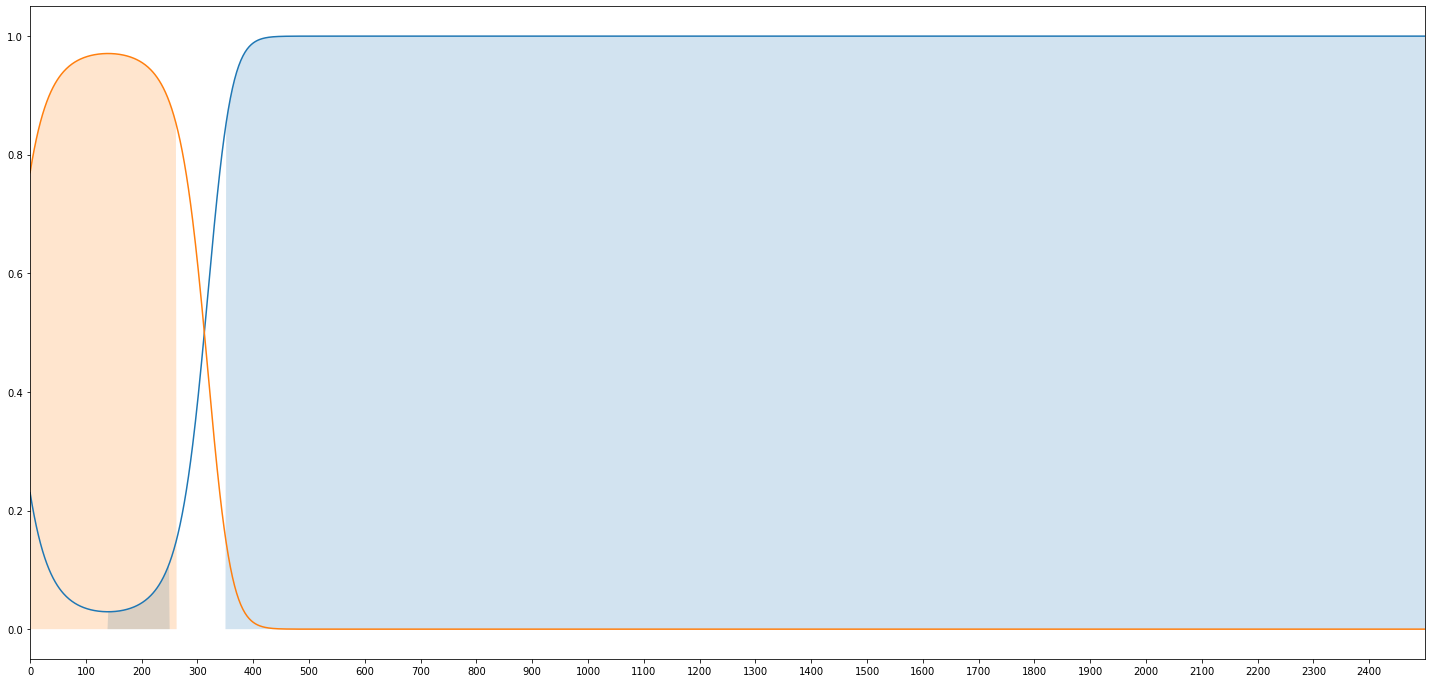

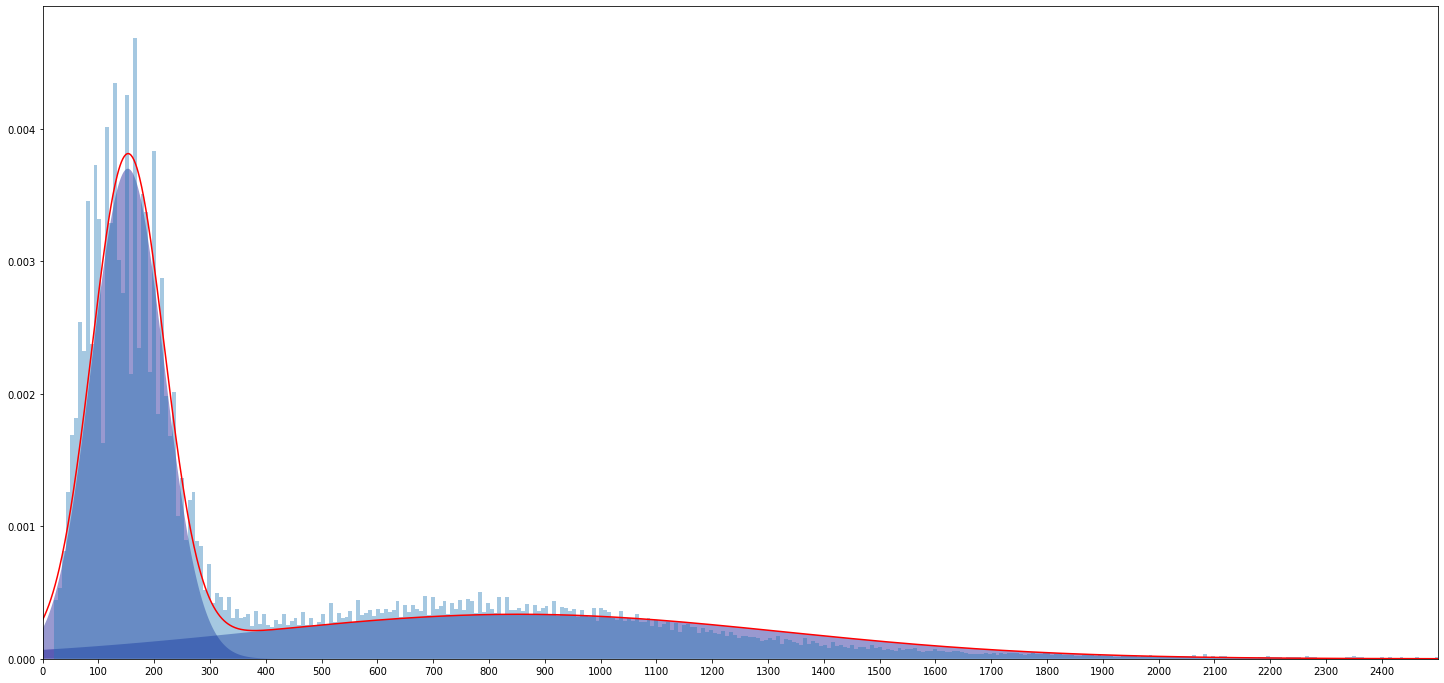

In [61]:
# Kernel density estimation of all autocorrections and predictions
Apply_Gaussian_mixture_models_2(log_combined_ite.iki,2,2500)

Percentage of outliers above 500 ms: 0.6140350877192983
Percentage of outliers above 750 ms: 0.45263157894736844
Percentage of outliers above 1000 ms: 0.28421052631578947
Percentage of outliers above 1250 ms: 0.15789473684210525
Percentage of outliers above 1500 ms: 0.08070175438596491
Percentage of outliers above 1750 ms: 0.031578947368421054
Percentage of outliers above 1875 ms: 0.0
Percentage of outliers above 2000 ms: 0.0
Percentage of outliers above 2125 ms: 0.0
Percentage of outliers above 2250 ms: 0.0
Percentage of outliers above 2500 ms: 0.0
Percentage of outliers above 3000 ms: 0.0
Percentage of outliers above 3500 ms: 0.0
Percentage of outliers above 4000 ms: 0.0
Percentage of outliers above 4500 ms: 0.0
85: 345.00000000000006
90: 354.99999999999994
85: 25.0
90: 42.5
90: 235.0
85: 252.50000000000003


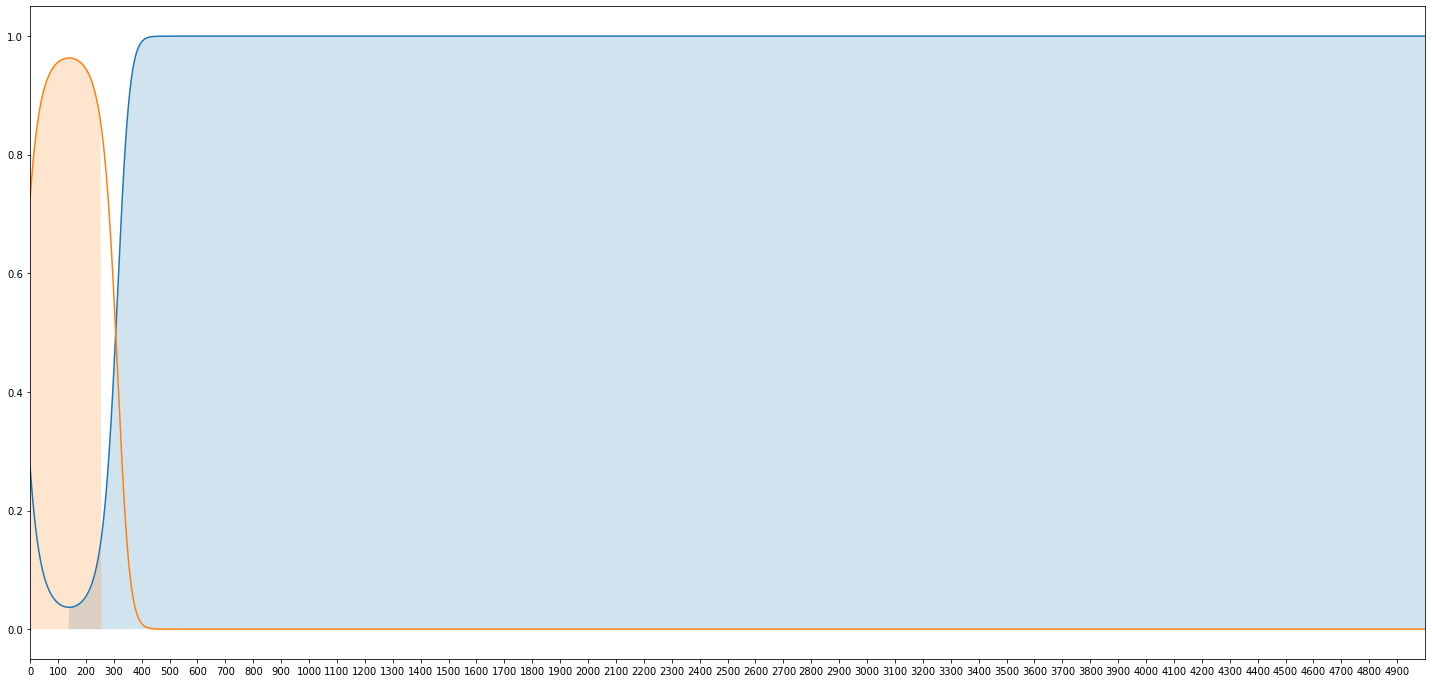

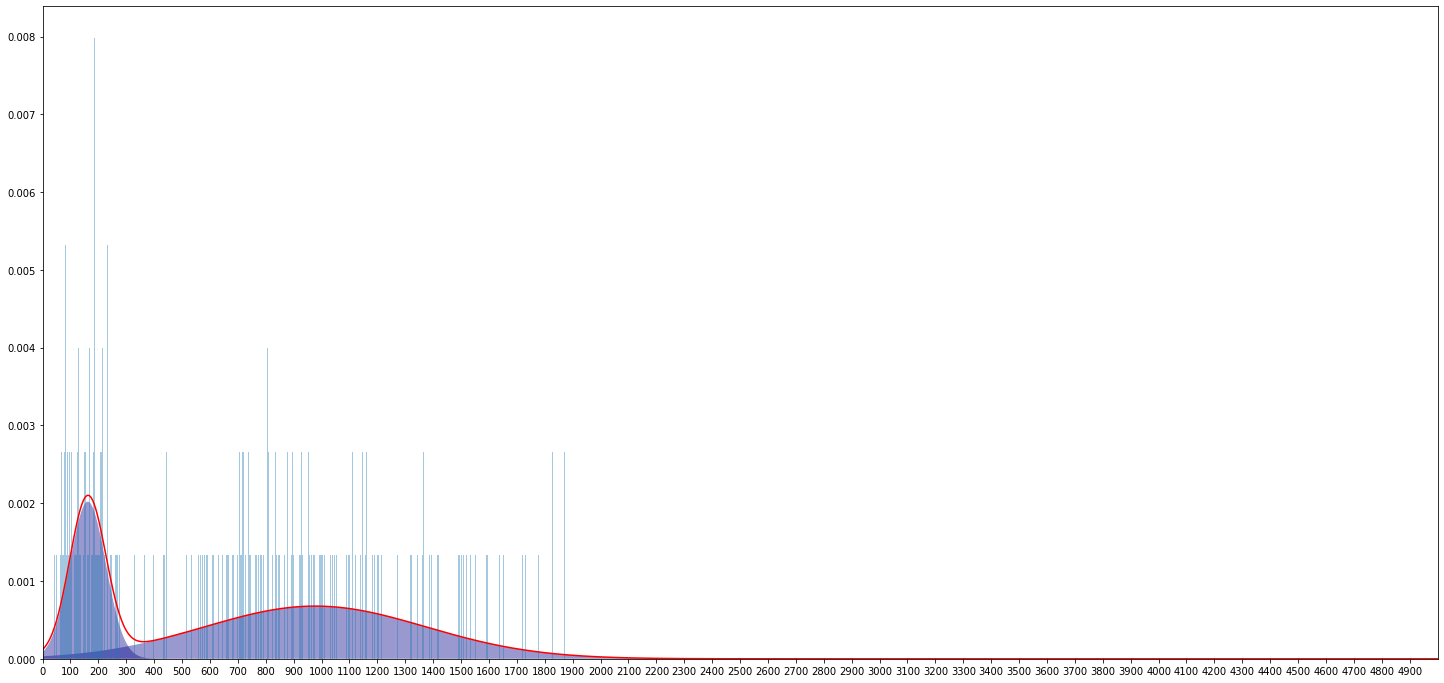

In [62]:
# 5 wpm user performance group
# Gaussian fitting of autocorrections and predictions 

Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 5].iki,2,5000)

Percentage of outliers above 500 ms: 0.6752577319587629
Percentage of outliers above 750 ms: 0.5756013745704467
Percentage of outliers above 1000 ms: 0.37628865979381443
Percentage of outliers above 1250 ms: 0.22852233676975944
Percentage of outliers above 1500 ms: 0.11168384879725086
Percentage of outliers above 1750 ms: 0.048109965635738834
Percentage of outliers above 1875 ms: 0.02577319587628866
Percentage of outliers above 2000 ms: 0.013745704467353952
Percentage of outliers above 2125 ms: 0.0
Percentage of outliers above 2250 ms: 0.0
Percentage of outliers above 2500 ms: 0.0
Percentage of outliers above 3000 ms: 0.0
Percentage of outliers above 3500 ms: 0.0
Percentage of outliers above 4000 ms: 0.0
Percentage of outliers above 4500 ms: 0.0
85: 354.99999999999994
90: 362.5
85: 47.5
90: 65.0
90: 250.0
85: 267.5


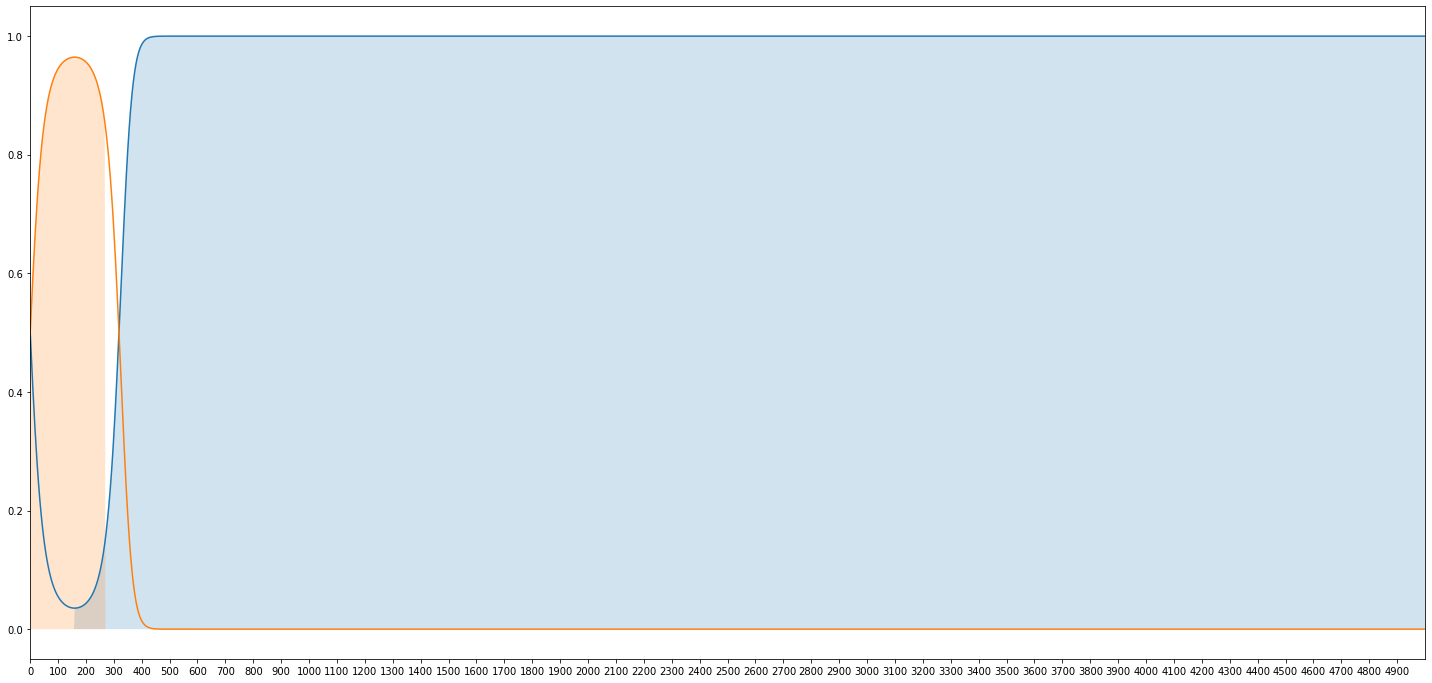

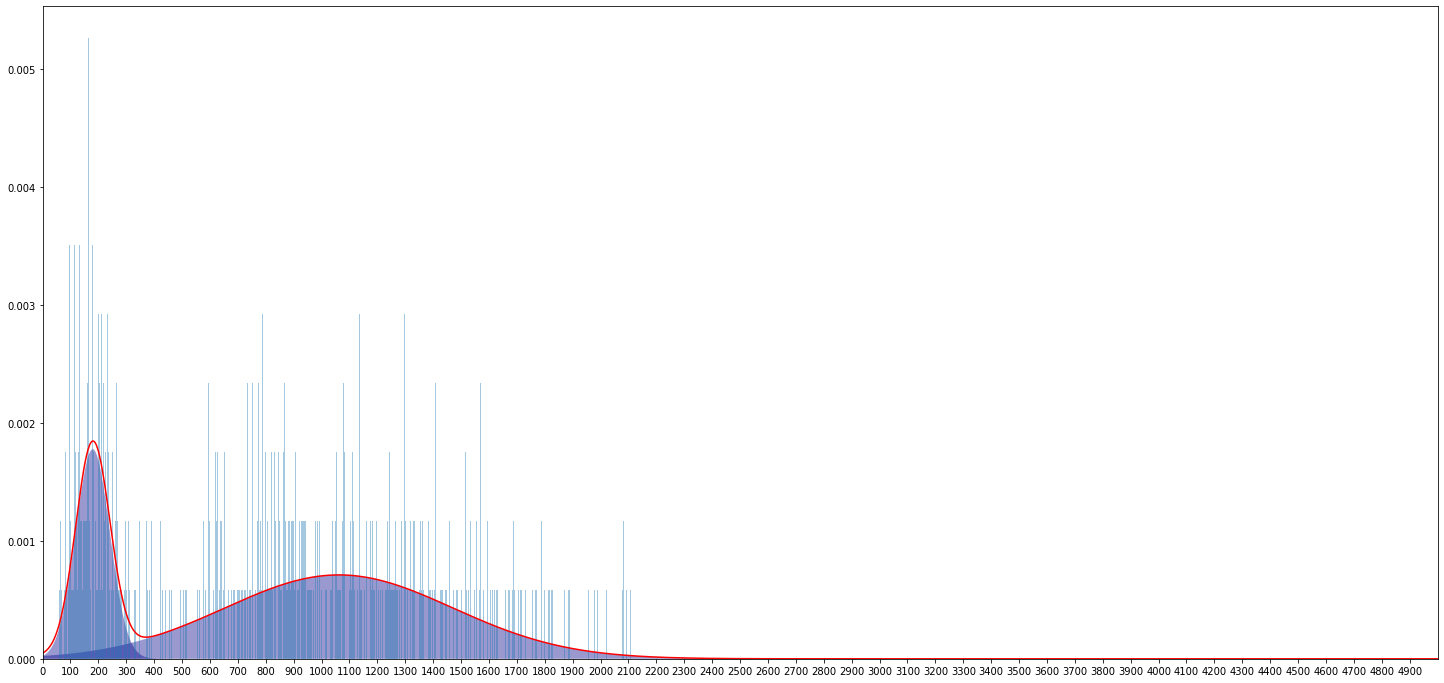

In [63]:
# 10 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 10].iki,2,5000)

Percentage of outliers above 500 ms: 0.7964765878535003
Percentage of outliers above 750 ms: 0.6573945294390356
Percentage of outliers above 1000 ms: 0.43069077422345853
Percentage of outliers above 1250 ms: 0.2220676866017617
Percentage of outliers above 1500 ms: 0.10152990264255911
Percentage of outliers above 1750 ms: 0.025498377375985166
Percentage of outliers above 1875 ms: 0.0
Percentage of outliers above 2000 ms: 0.0
Percentage of outliers above 2125 ms: 0.0
Percentage of outliers above 2250 ms: 0.0
Percentage of outliers above 2500 ms: 0.0
Percentage of outliers above 3000 ms: 0.0
Percentage of outliers above 3500 ms: 0.0
Percentage of outliers above 4000 ms: 0.0
Percentage of outliers above 4500 ms: 0.0
85: 1003.5000000000001
90: 1038.0
90: 1162.5
85: 1198.5
85: 556.5
90: 576.0
90: 756.0
85: 784.5
85: 1396.5
90: 1419.0
90: 399.0
85: 418.50000000000006


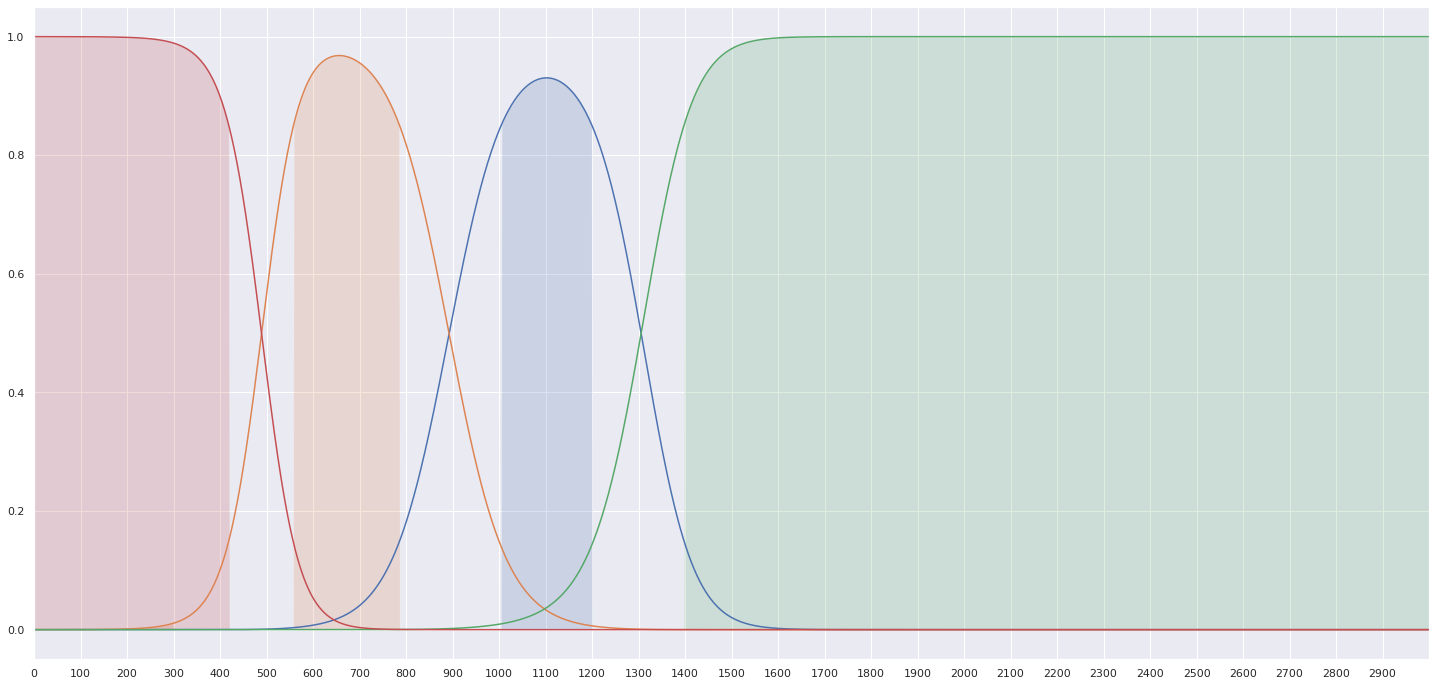

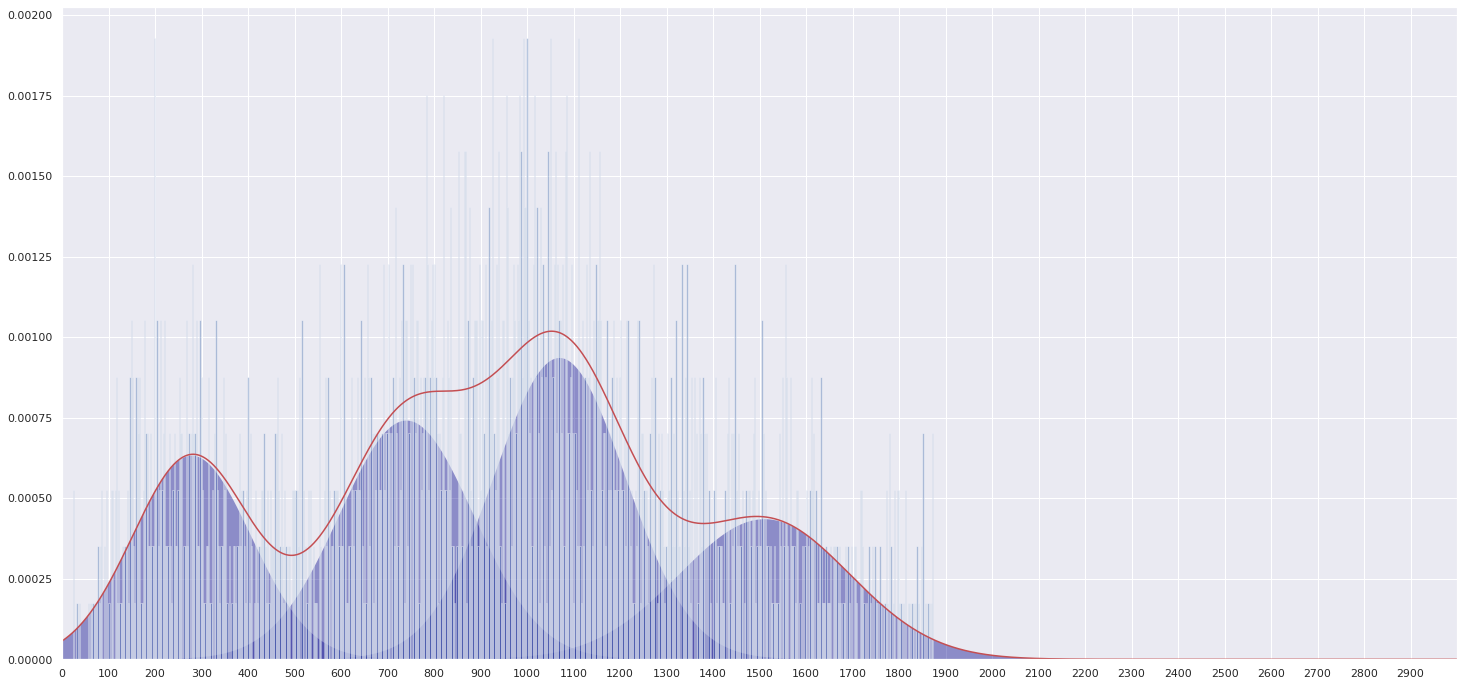

In [76]:
# 15 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 15].iki,4,3000)

Percentage of outliers above 500 ms: 0.6808258588593671
Percentage of outliers above 750 ms: 0.5082078185818243
Percentage of outliers above 1000 ms: 0.28854290066001015
Percentage of outliers above 1250 ms: 0.13132509730918937
Percentage of outliers above 1500 ms: 0.04467761042477576
Percentage of outliers above 1750 ms: 0.0
Percentage of outliers above 1875 ms: 0.0
Percentage of outliers above 2000 ms: 0.0
Percentage of outliers above 2125 ms: 0.0
Percentage of outliers above 2250 ms: 0.0
Percentage of outliers above 2500 ms: 0.0
Percentage of outliers above 3000 ms: 0.0
Percentage of outliers above 3500 ms: 0.0
Percentage of outliers above 4000 ms: 0.0
Percentage of outliers above 4500 ms: 0.0
85: 424.49999999999994
90: 438.0
85: 82.5
90: 130.5
90: 228.0
85: 276.0


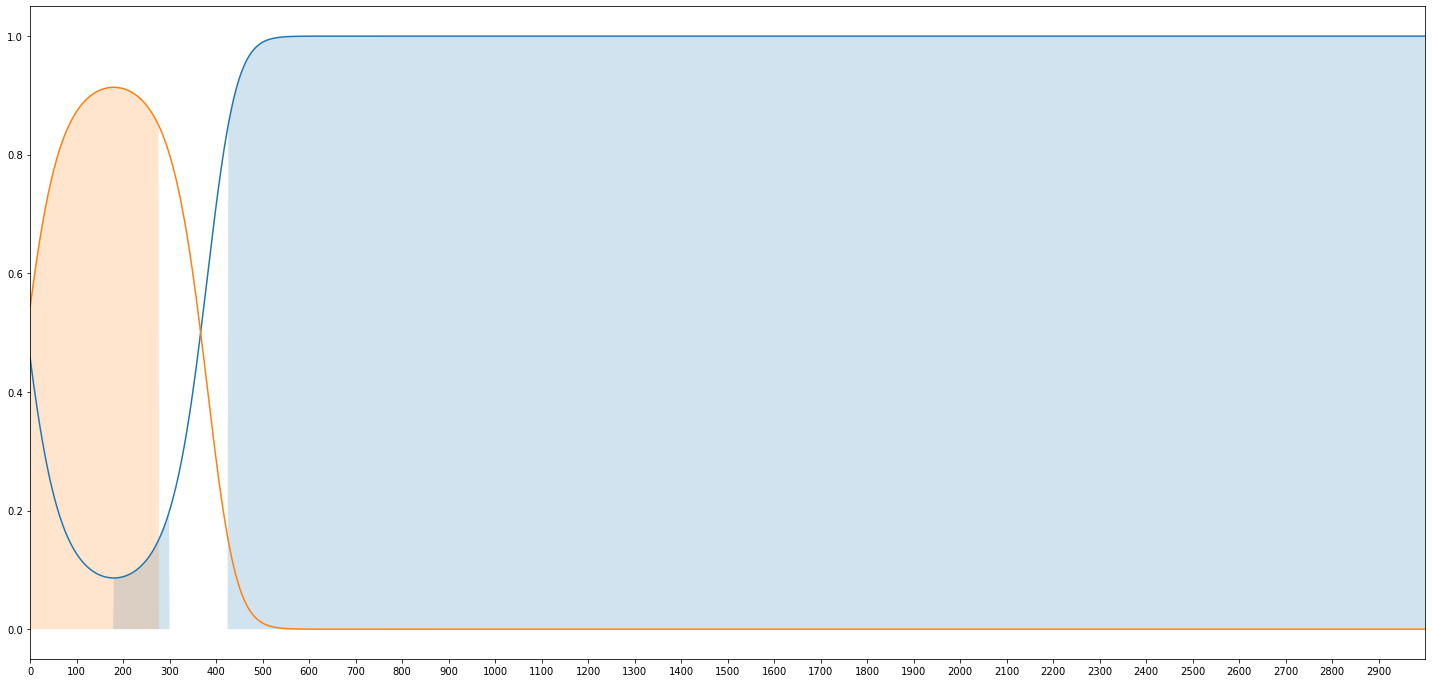

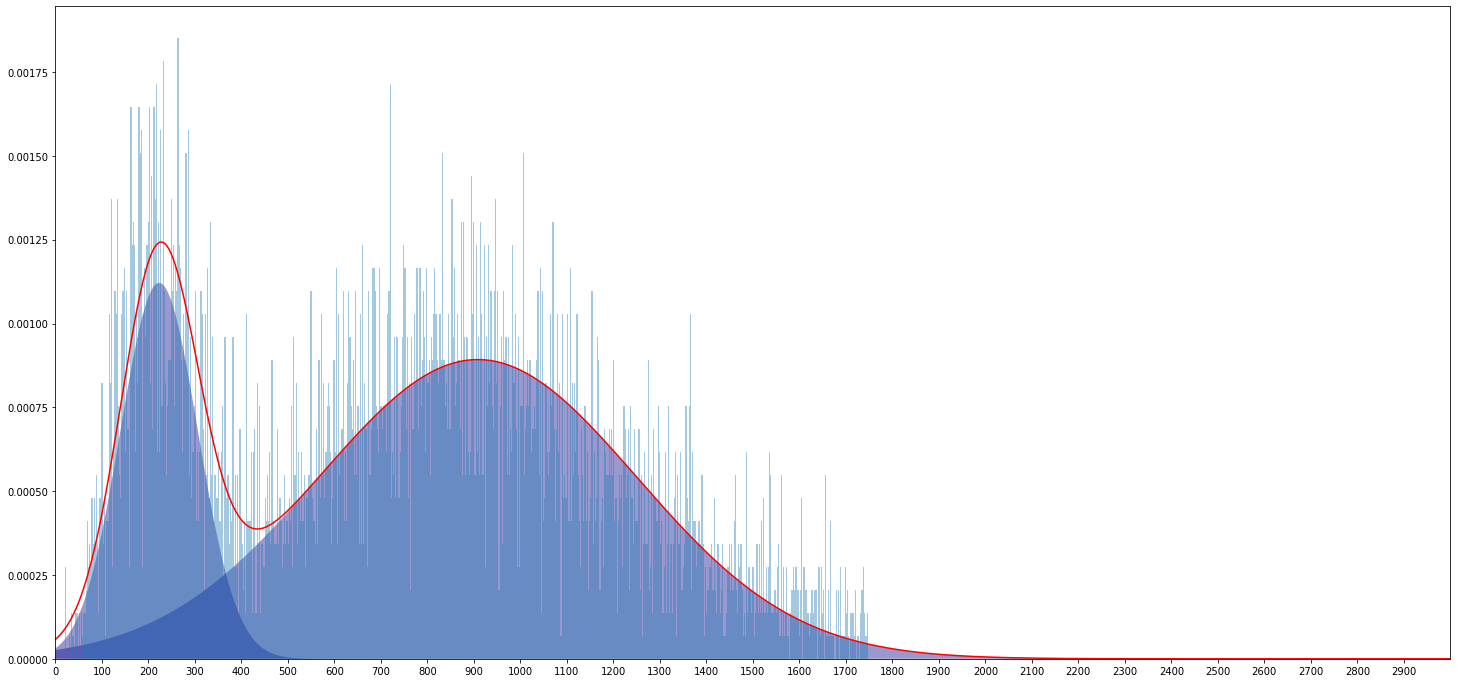

In [70]:
# 20 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 20].iki,2,3000)

Percentage of outliers above 500 ms: 0.5733406173176727
Percentage of outliers above 750 ms: 0.4040790312300829
Percentage of outliers above 1000 ms: 0.2044978603296003
Percentage of outliers above 1250 ms: 0.06810525357370481
Percentage of outliers above 1500 ms: 0.0
Percentage of outliers above 1750 ms: 0.0
Percentage of outliers above 1875 ms: 0.0
Percentage of outliers above 2000 ms: 0.0
Percentage of outliers above 2125 ms: 0.0
Percentage of outliers above 2250 ms: 0.0
Percentage of outliers above 2500 ms: 0.0
Percentage of outliers above 3000 ms: 0.0
Percentage of outliers above 3500 ms: 0.0
Percentage of outliers above 4000 ms: 0.0
Percentage of outliers above 4500 ms: 0.0
85: 4.5
90: 25.500000000000004
90: 280.5
85: 300.0
85: 408.00000000000006
90: 418.50000000000006


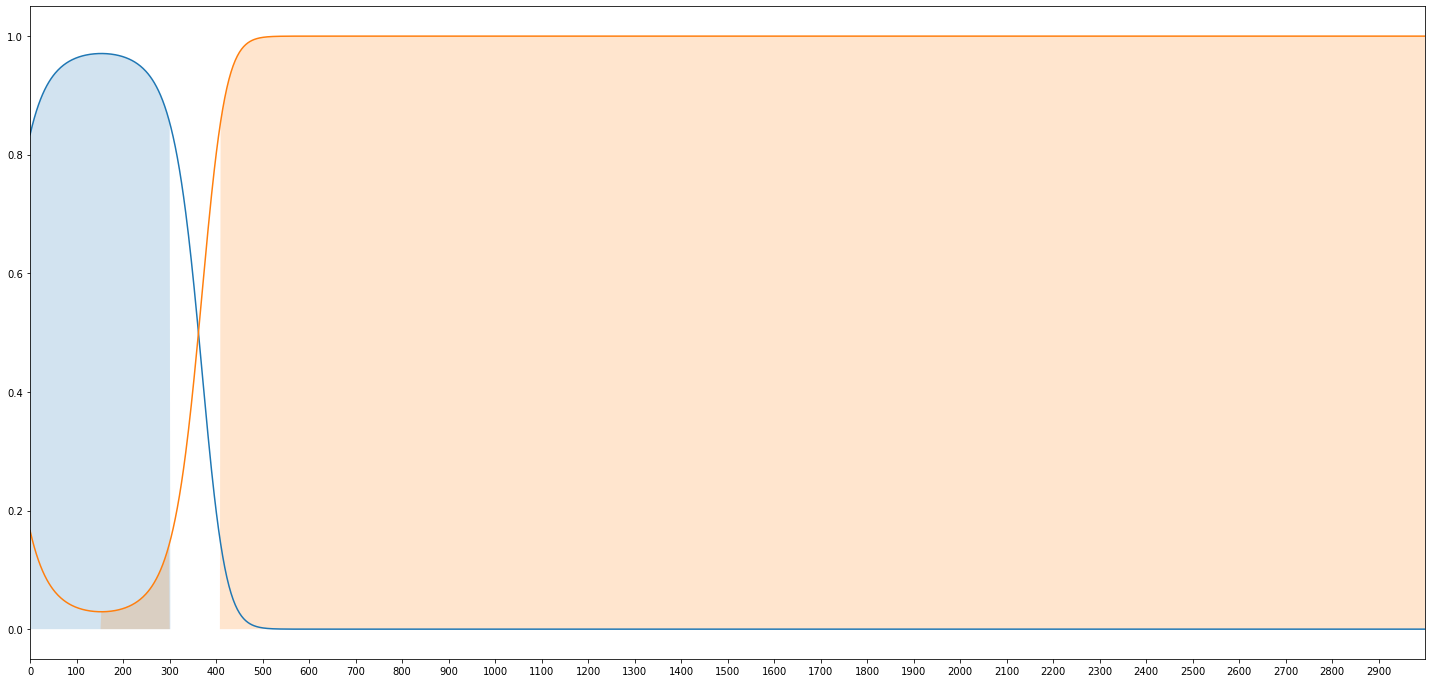

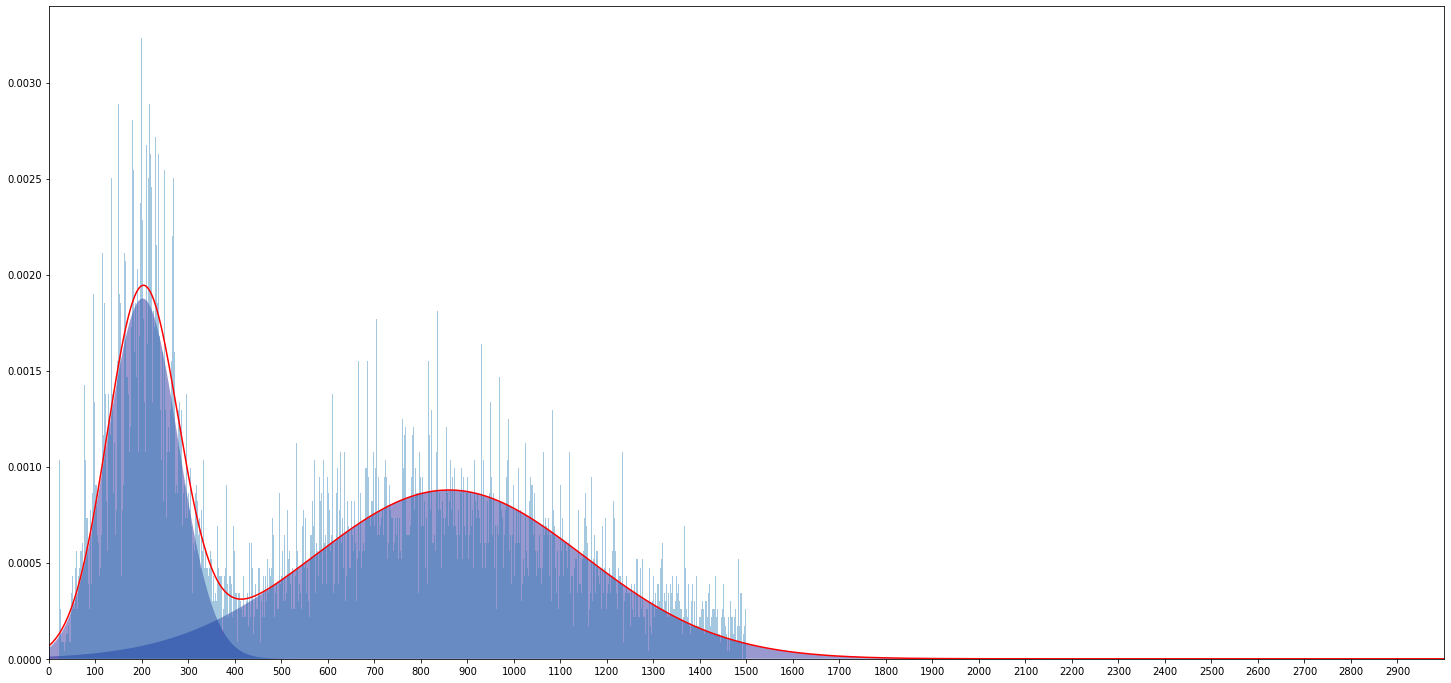

In [66]:
# 25 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 25].iki,2,3000)

Percentage of outliers above 500 ms: 0.4376637963309622
Percentage of outliers above 750 ms: 0.3004492699363534
Percentage of outliers above 1000 ms: 0.14938225383751405
Percentage of outliers above 1250 ms: 0.047422937726194936
Percentage of outliers above 1500 ms: 0.0
Percentage of outliers above 1750 ms: 0.0
Percentage of outliers above 1875 ms: 0.0
Percentage of outliers above 2000 ms: 0.0
Percentage of outliers above 2125 ms: 0.0
Percentage of outliers above 2250 ms: 0.0
Percentage of outliers above 2500 ms: 0.0
Percentage of outliers above 3000 ms: 0.0
Percentage of outliers above 3500 ms: 0.0
Percentage of outliers above 4000 ms: 0.0
Percentage of outliers above 4500 ms: 0.0
85: 0.0
90: 16.5
90: 277.5
85: 294.0
85: 385.5
90: 394.5


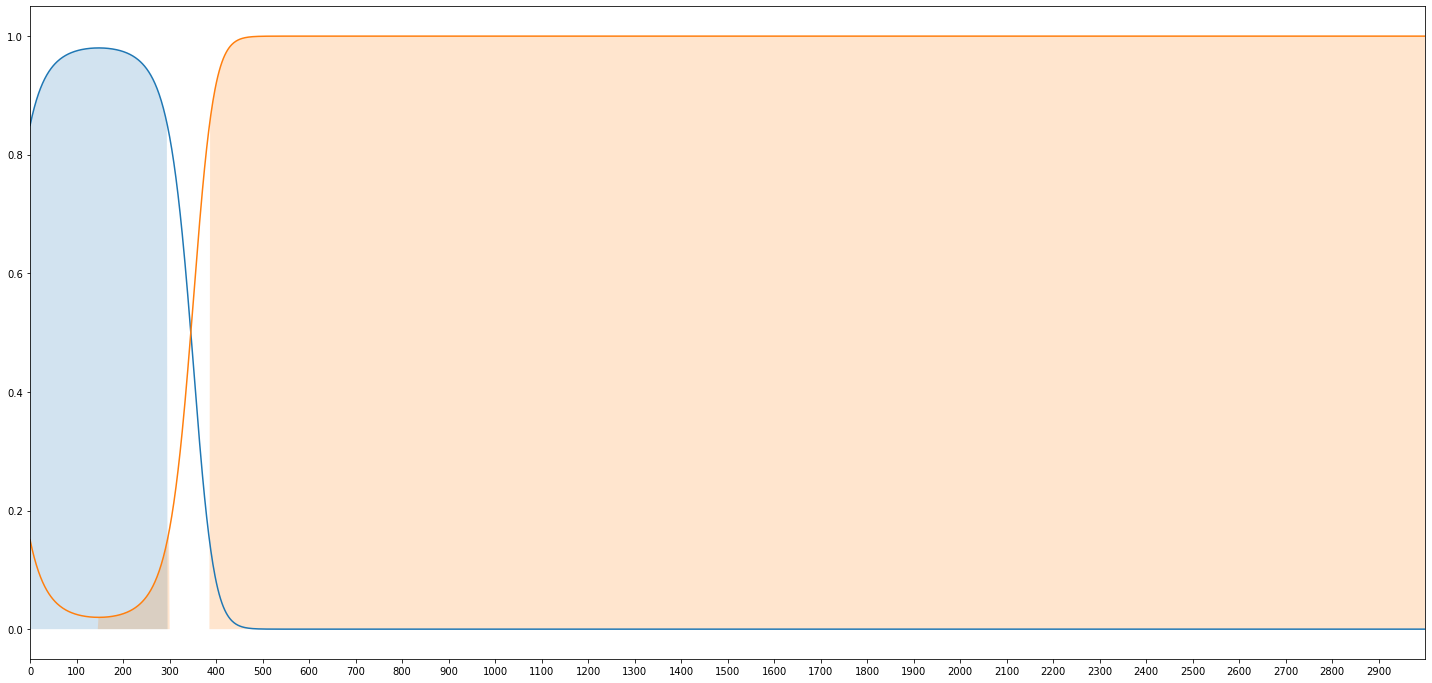

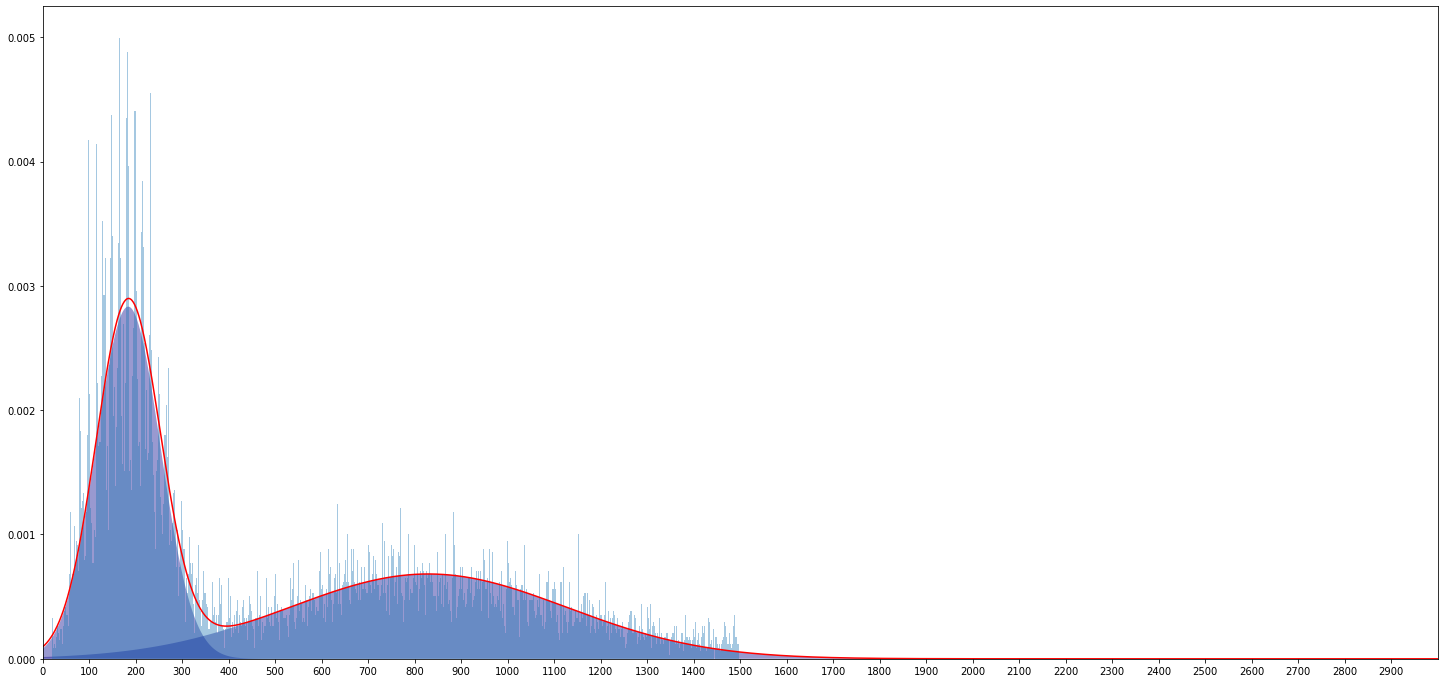

In [67]:
# 30 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 30].iki,2,3000)

90: 12.0
90: 278.0
85: 293.0
85: 380.0
90: 389.0


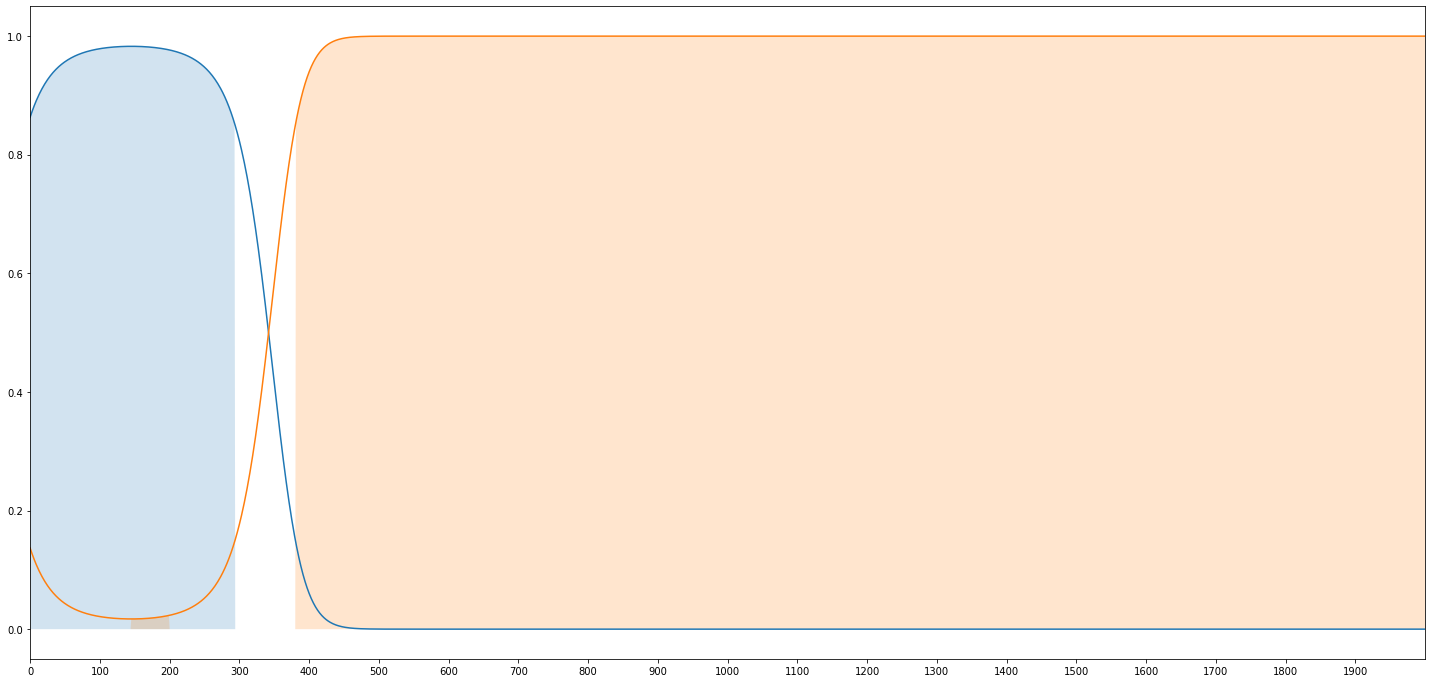

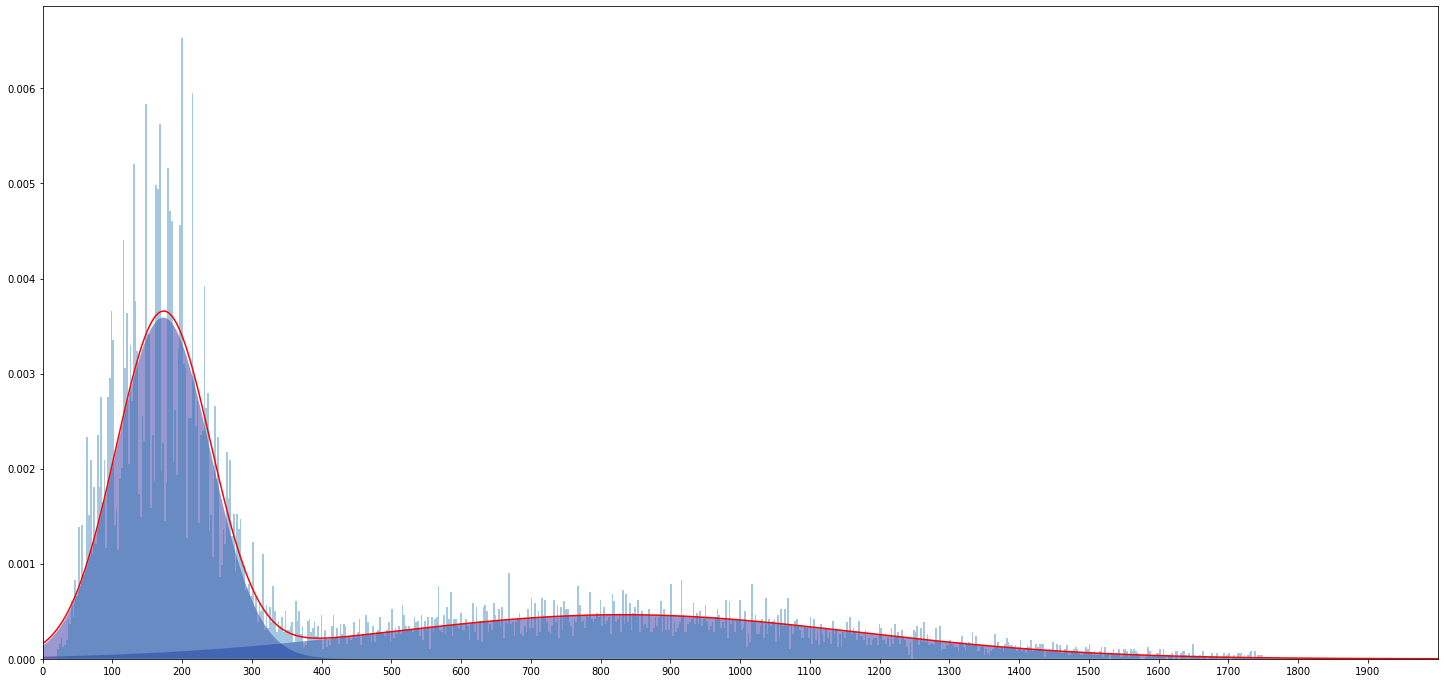

In [64]:
# 35 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 35].iki,2,2000)

90: 6.25
90: 266.25
85: 278.75
85: 356.24999999999994
90: 365.0


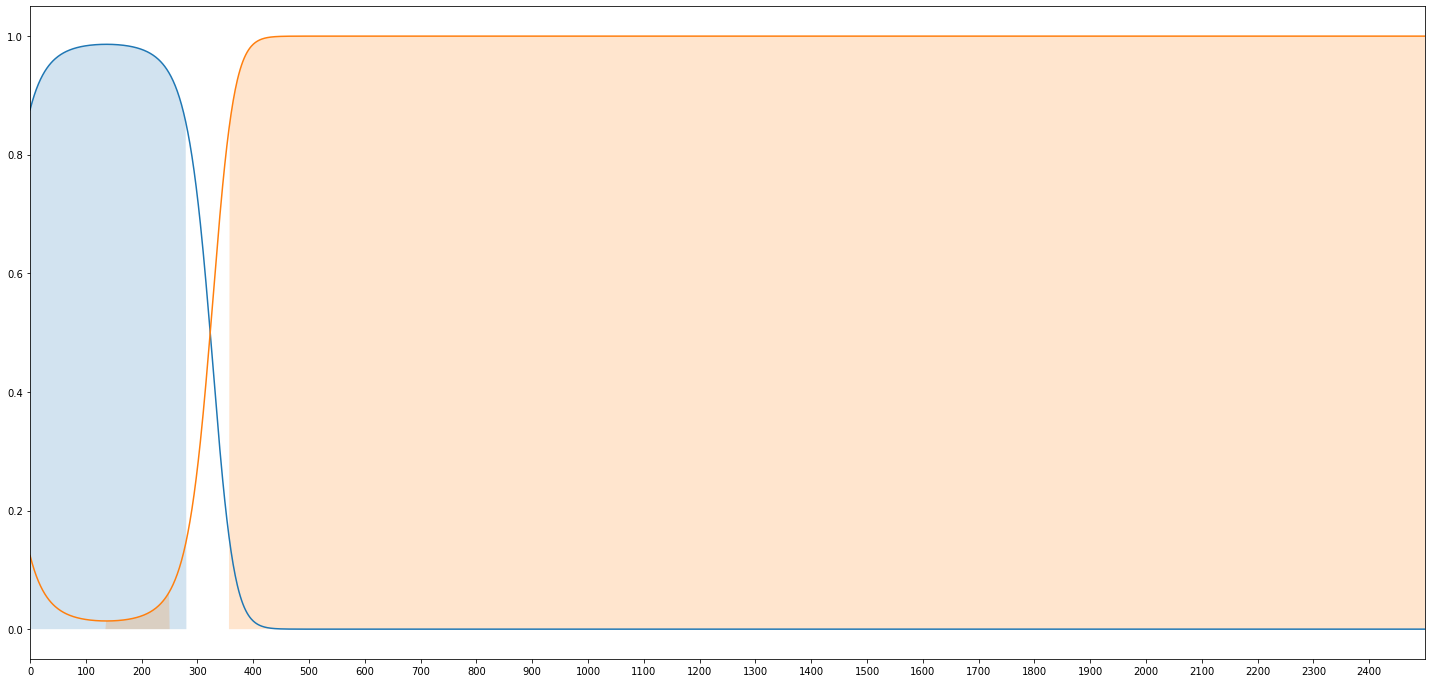

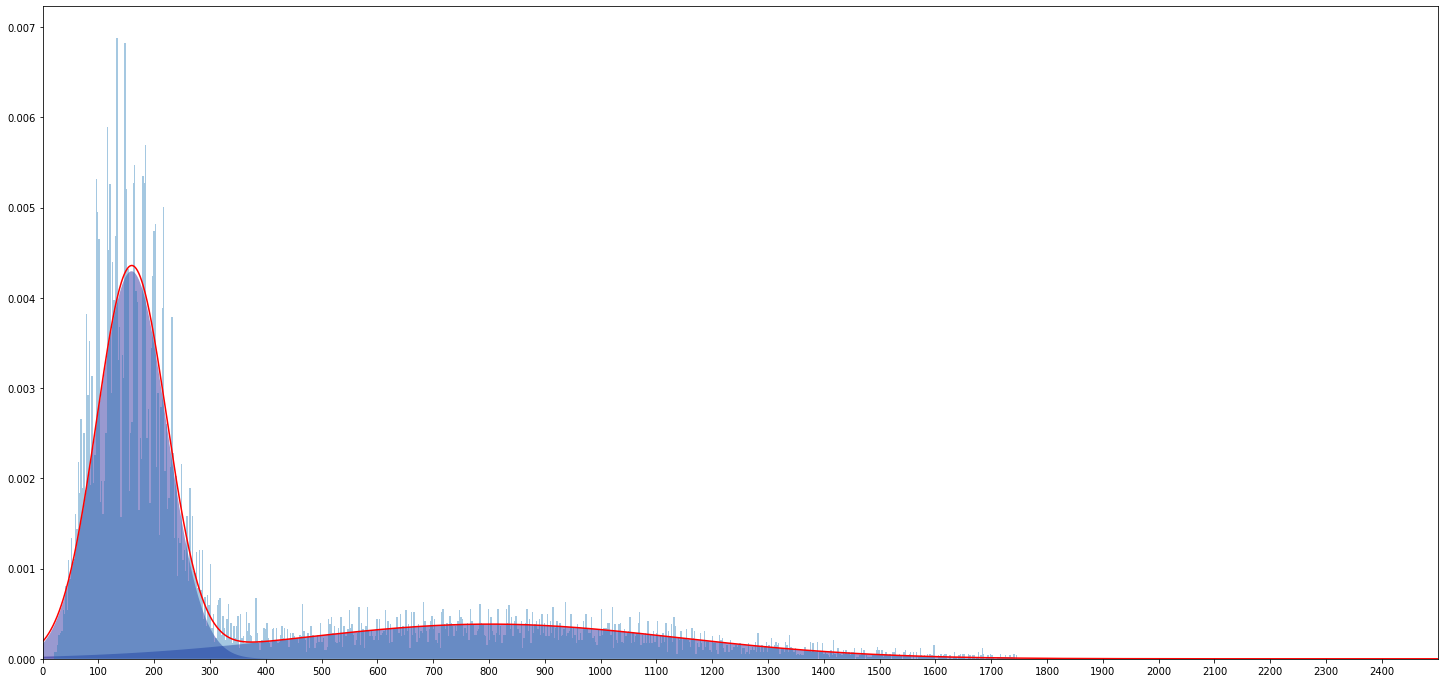

In [66]:
# 40 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 40].iki,2,2500)

90: 264.8
85: 277.59999999999997
85: 351.2
90: 359.2


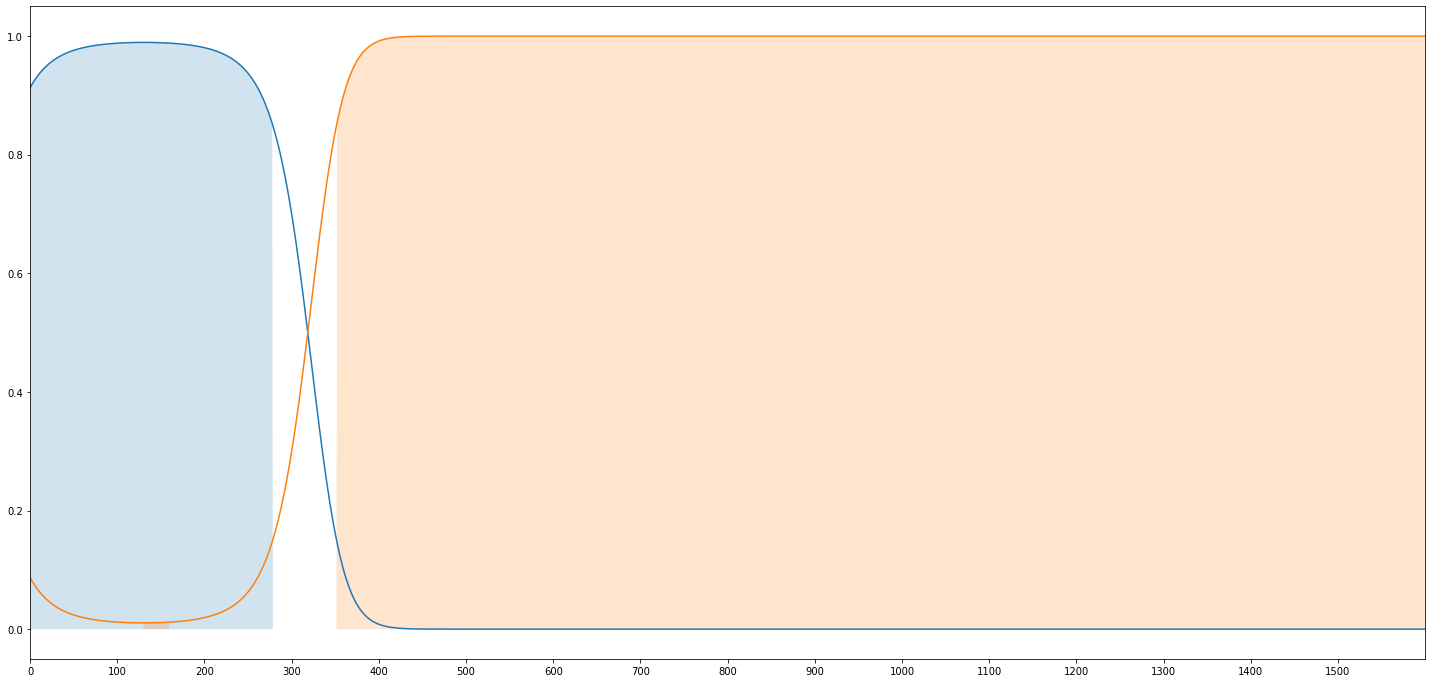

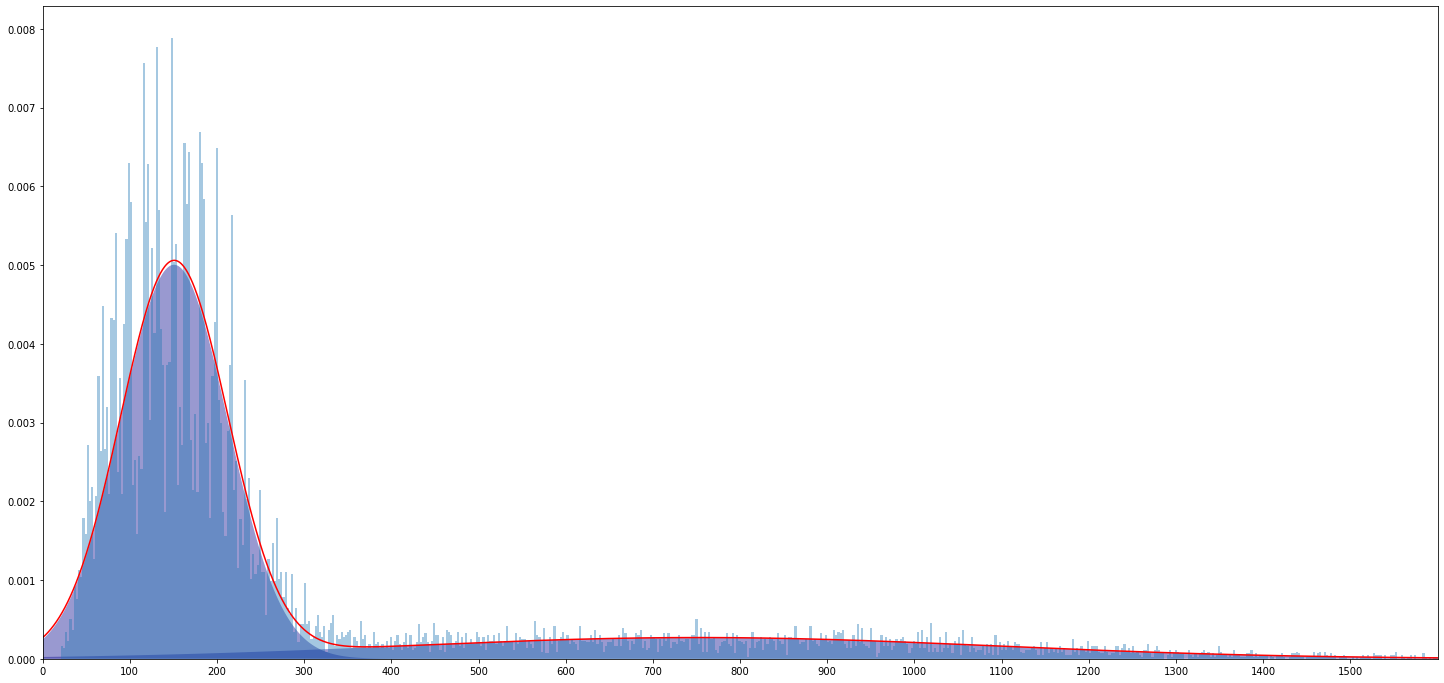

In [68]:
# 45 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 45].iki,2,1600)

90: 259.5
85: 271.5
85: 339.75
90: 347.25


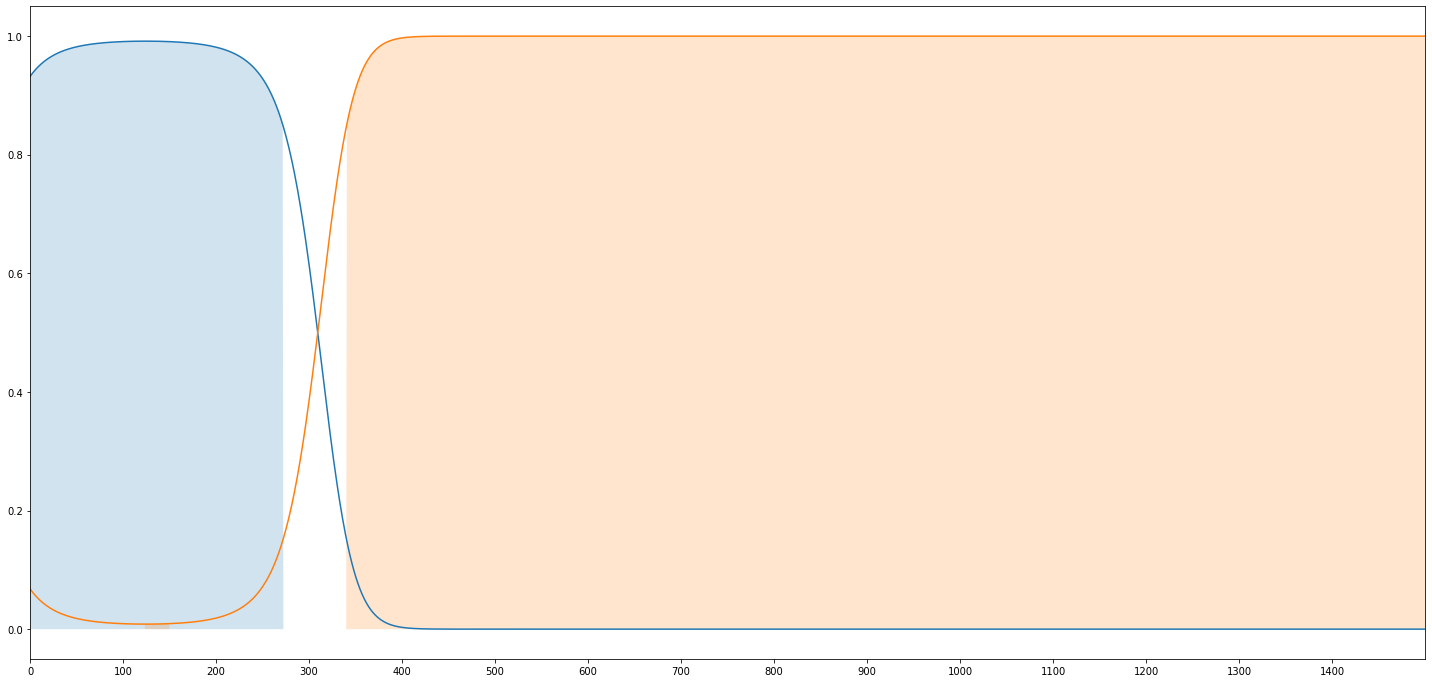

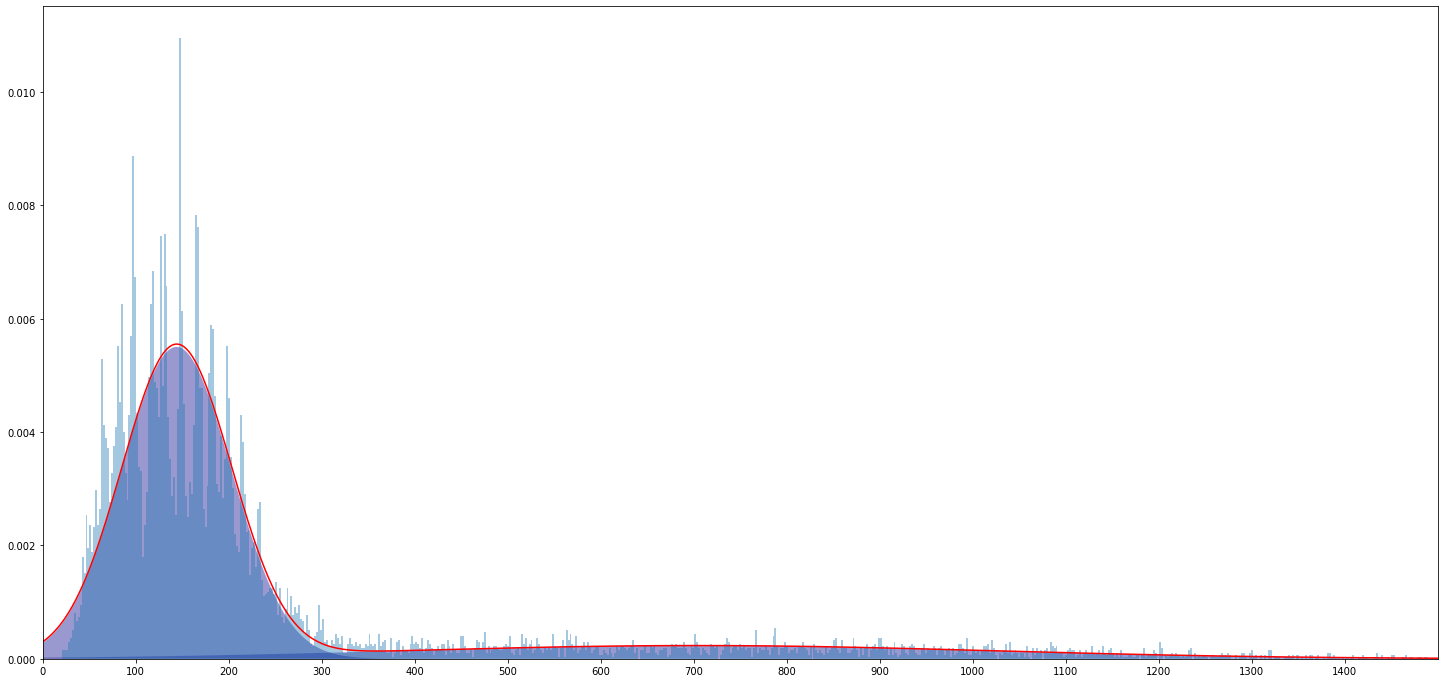

In [69]:
# 50 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 50].iki,2,1500)

90: 251.5
85: 262.5
85: 327.0
90: 334.0


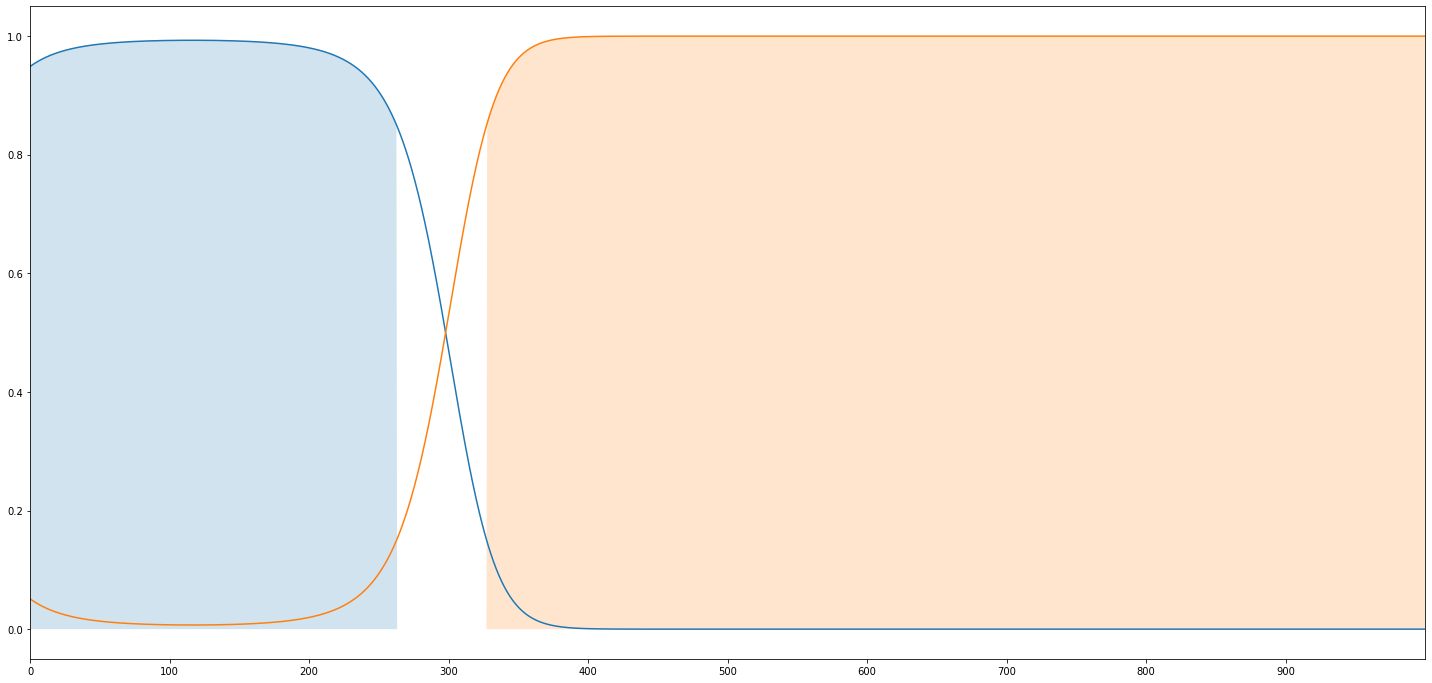

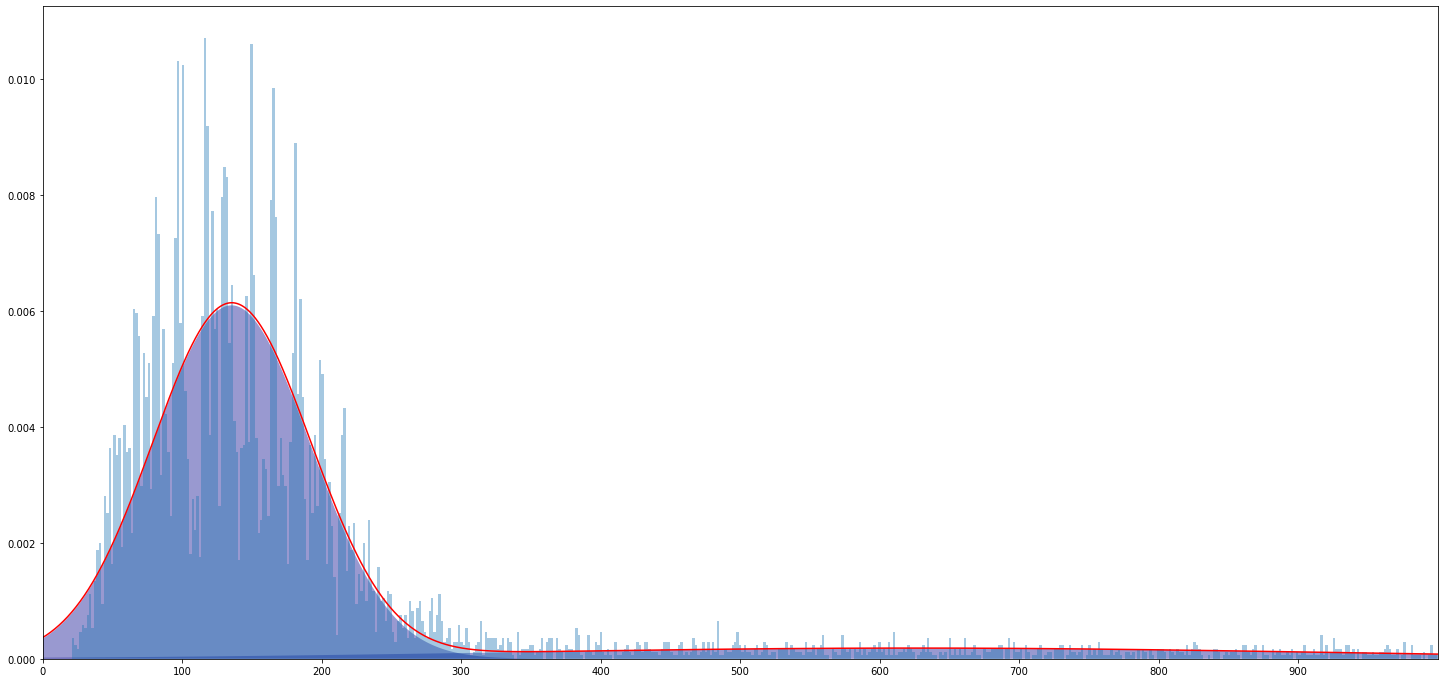

In [70]:
# 55 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 55].iki,2,1000)

85: 315.0
90: 321.5
90: 241.5
85: 252.0


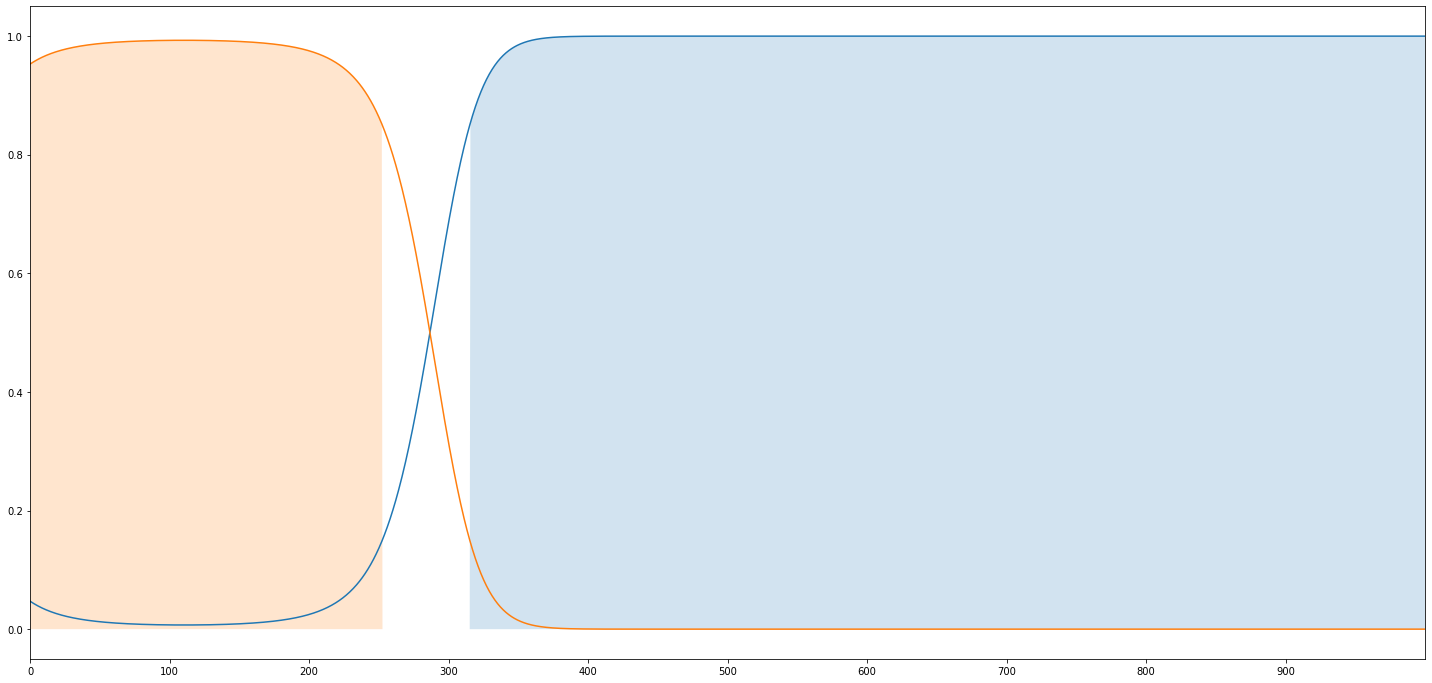

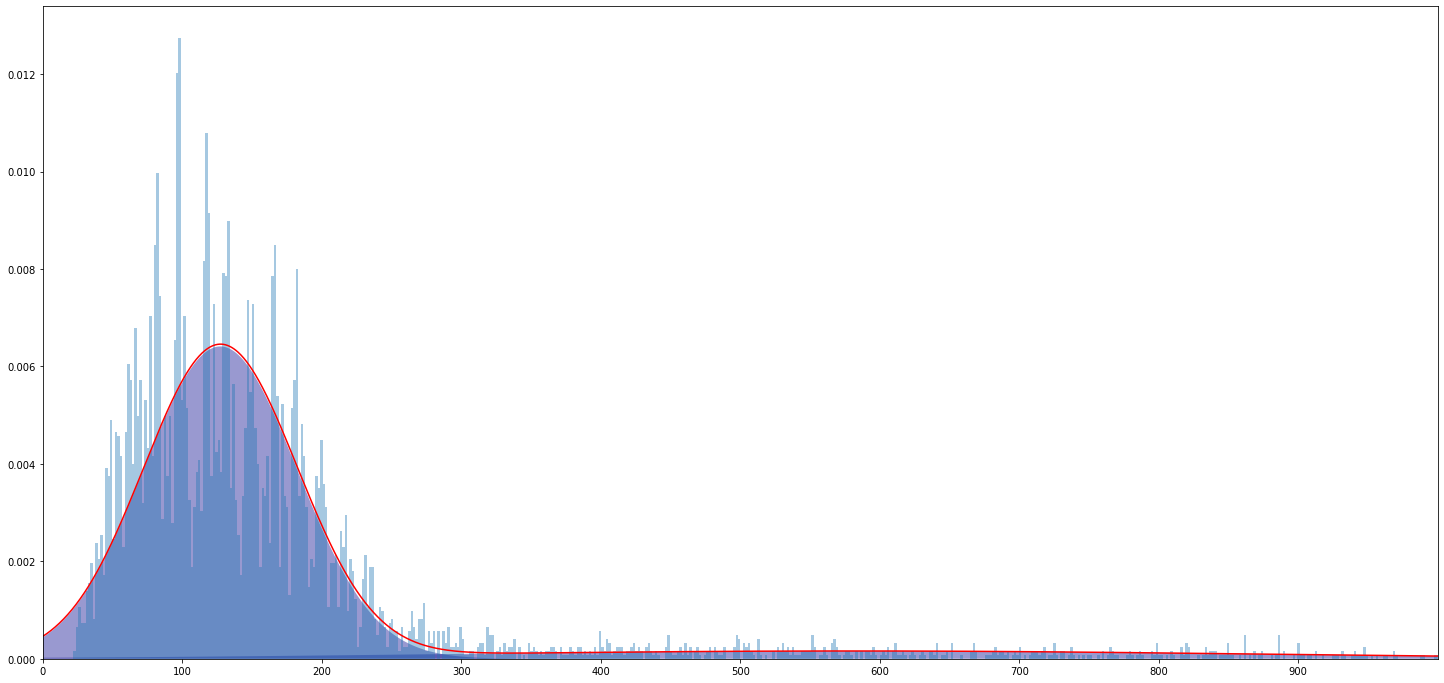

In [71]:
# 60 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 60].iki,2,1000)

90: 225.2
85: 235.6
85: 297.2
90: 304.0


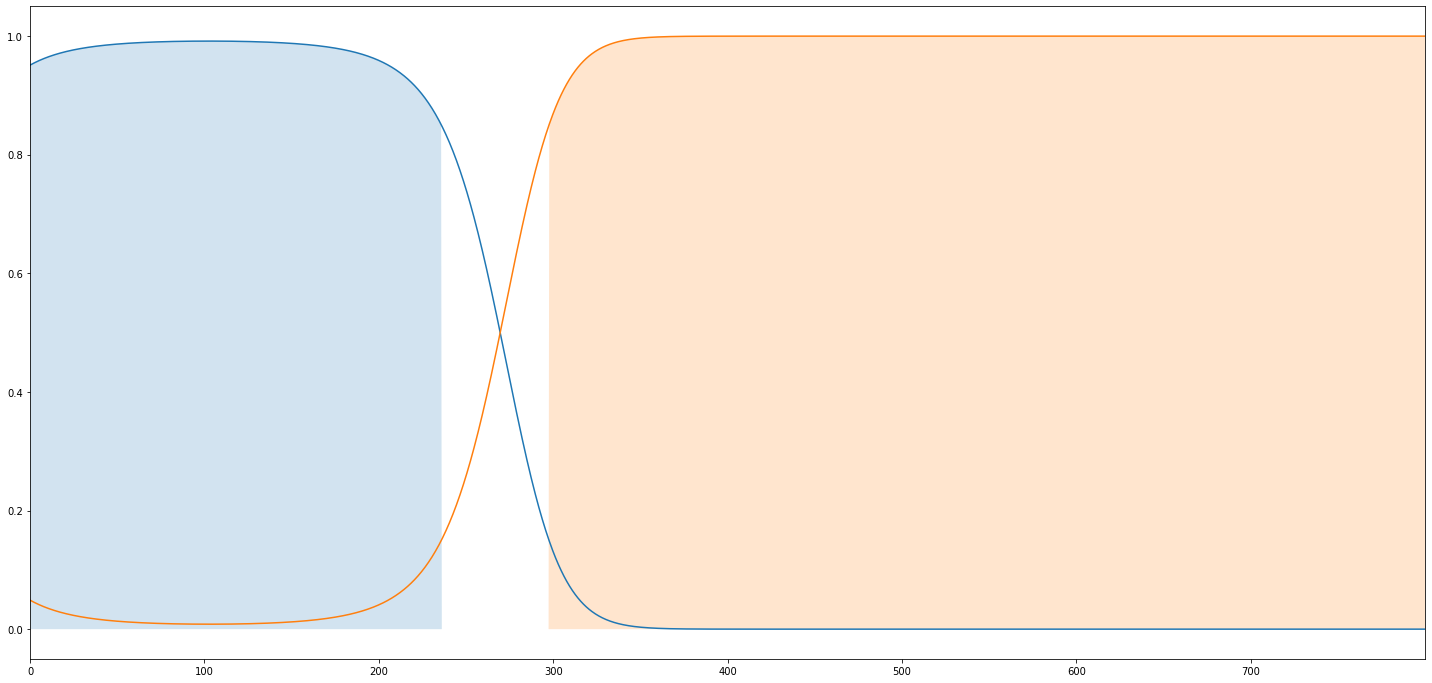

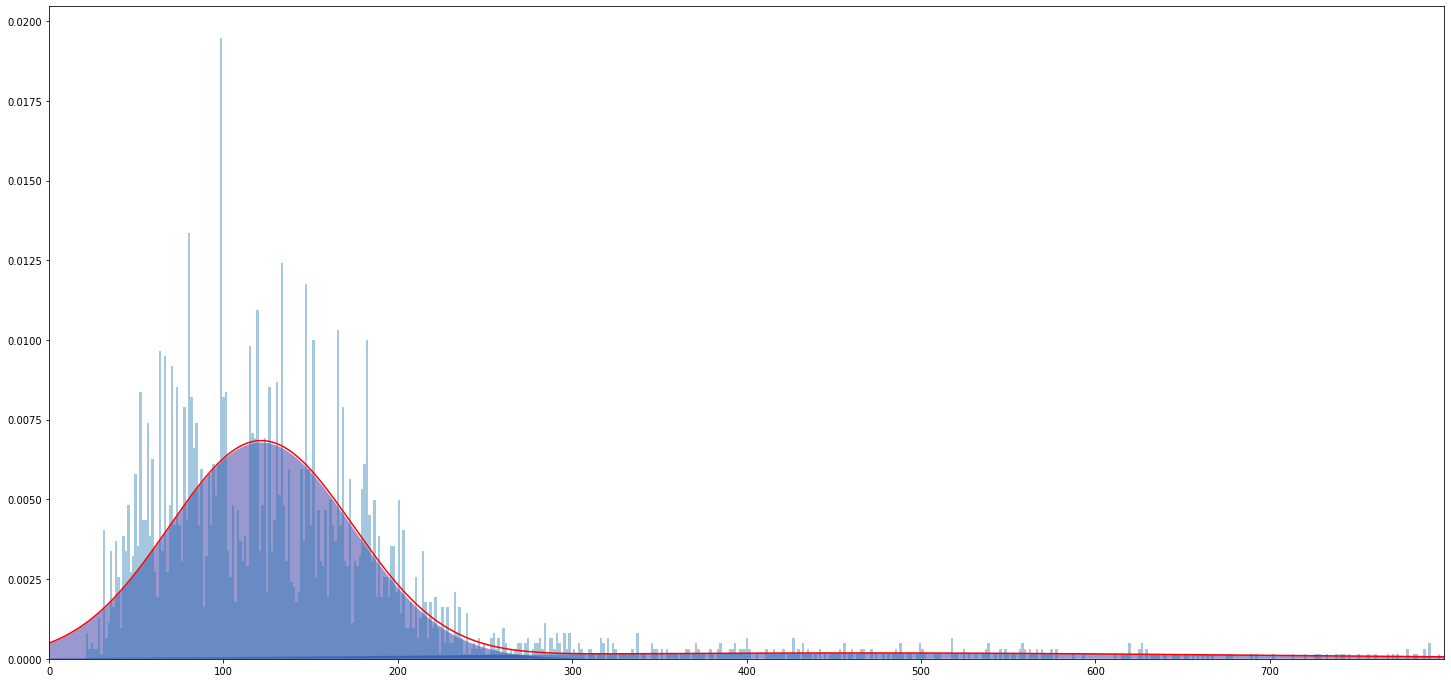

In [72]:
# 65 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 65].iki,2,800)

90: 225.6
85: 236.10000000000002
85: 297.0
90: 303.9


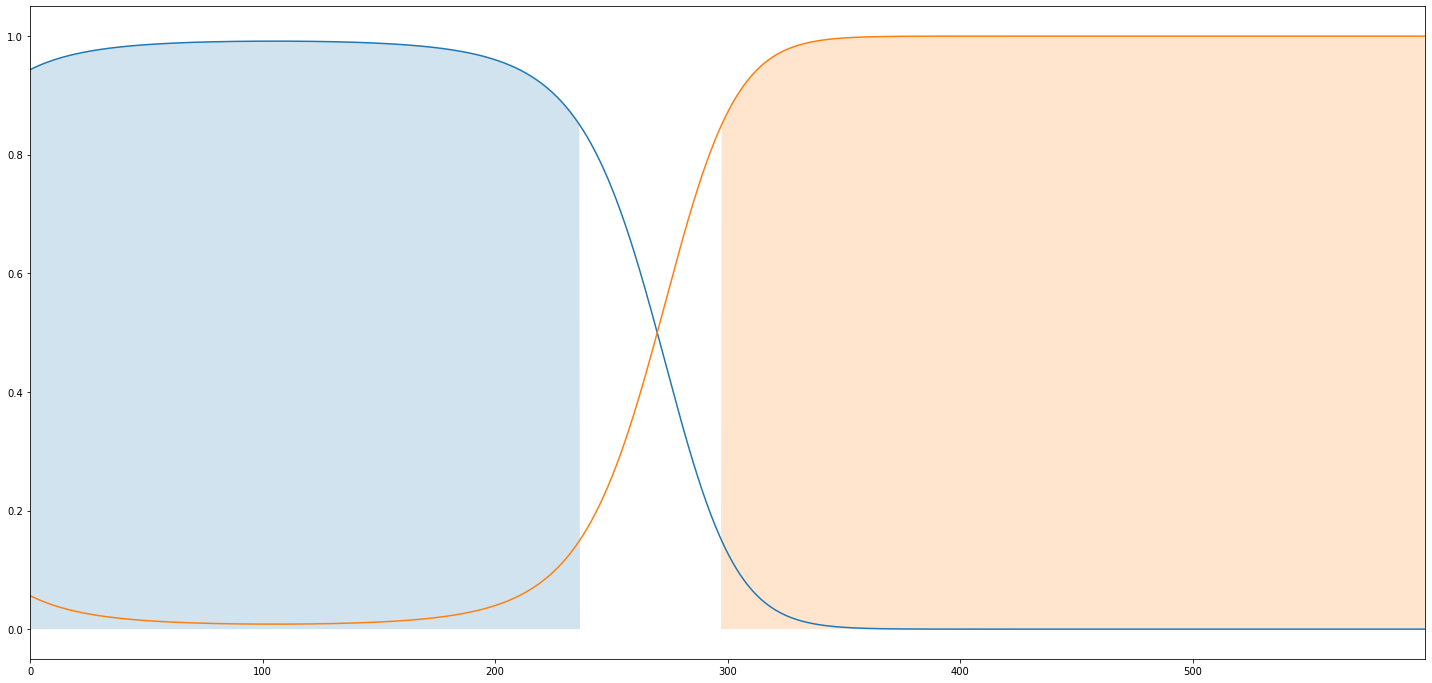

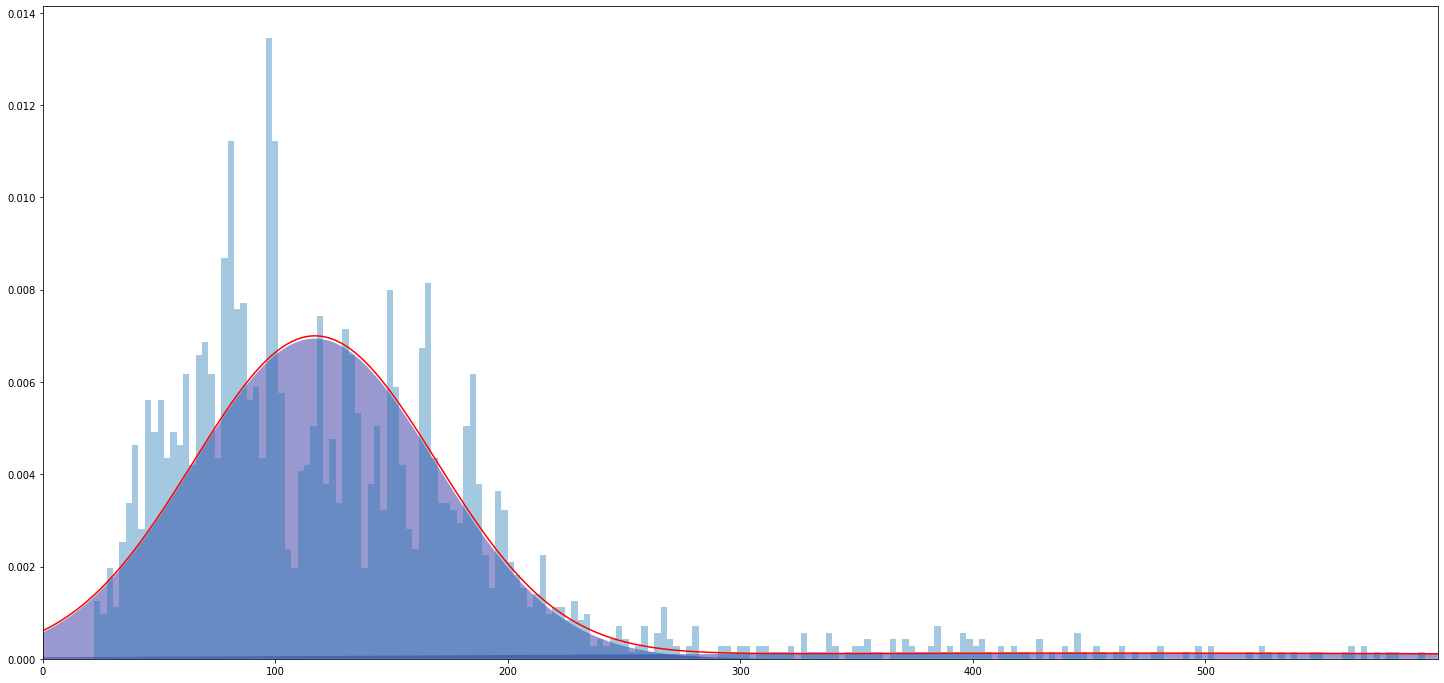

In [73]:
# 70 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 70].iki,2,600)

90: 224.25
85: 233.25
85: 290.25
90: 296.25


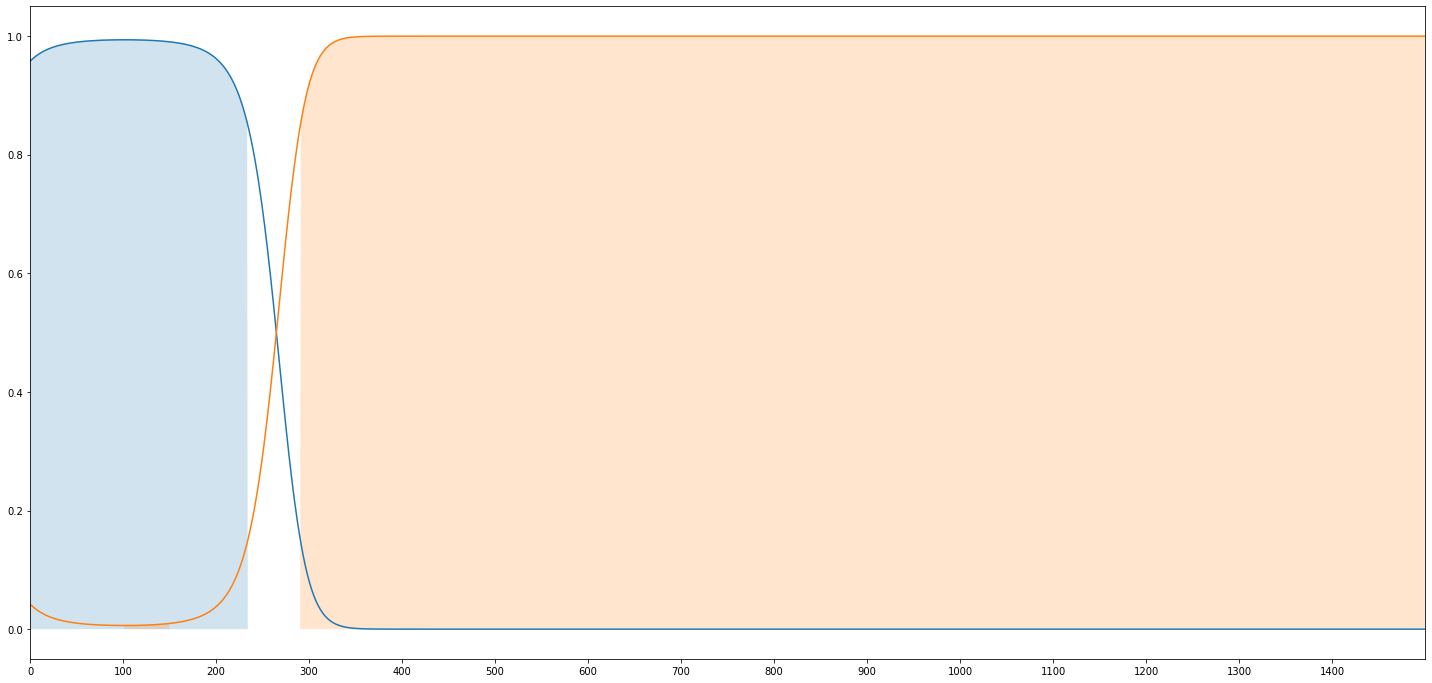

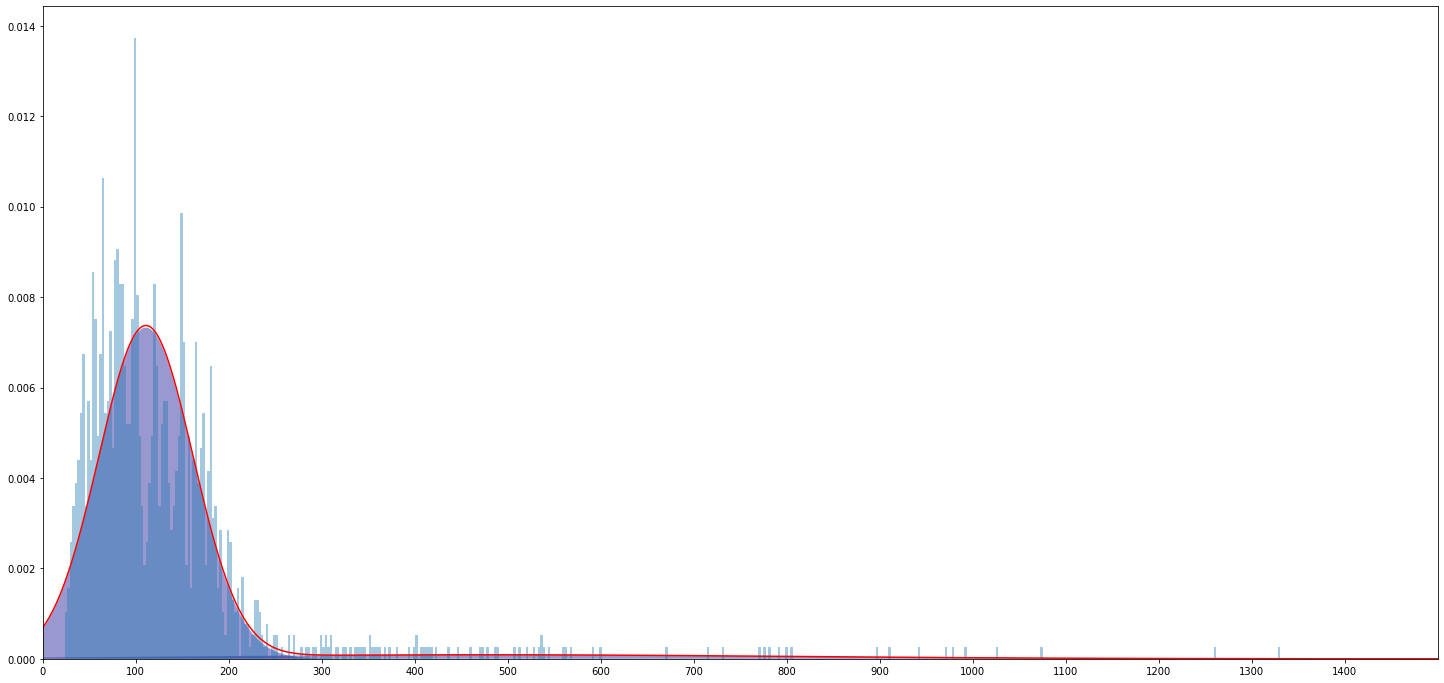

In [76]:
# 75 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 75].iki,2,1500)

90: 225.9
85: 234.60000000000002
85: 288.59999999999997
90: 294.6


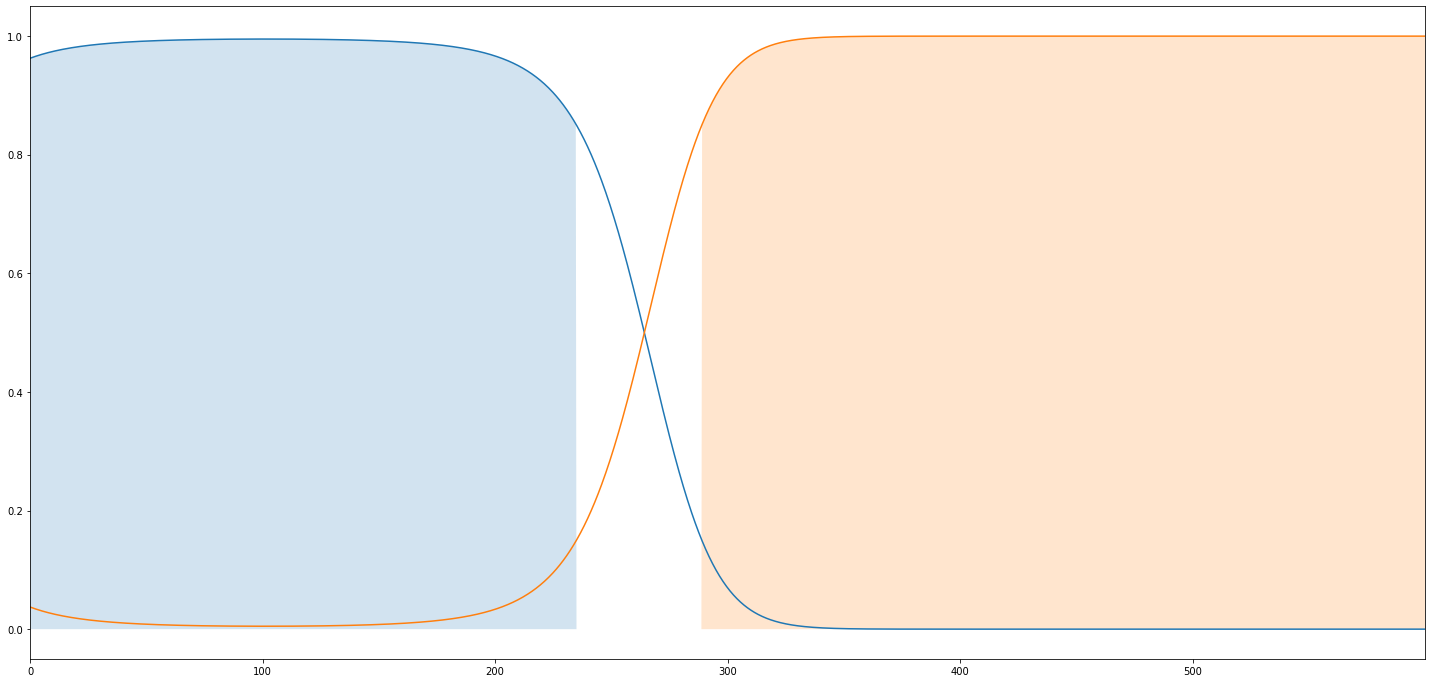

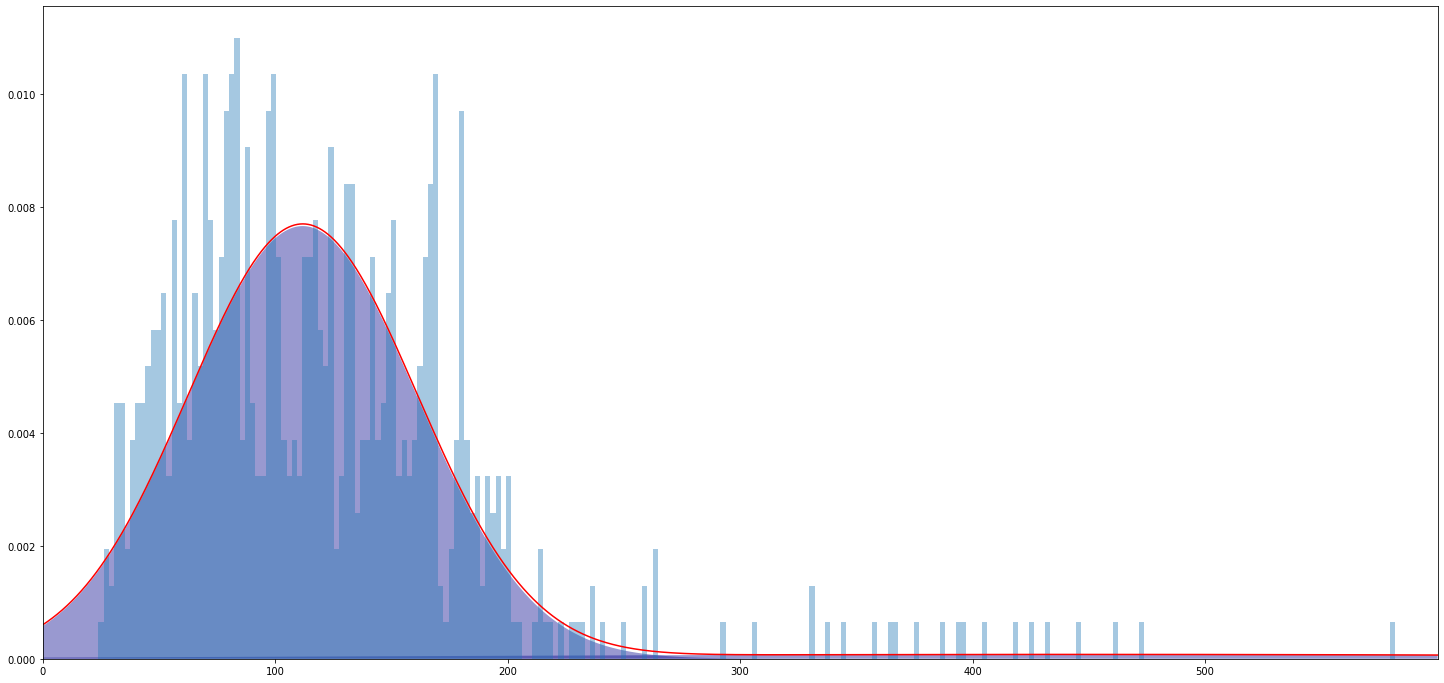

In [78]:
# 80 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 80].iki,2,600)

85: 253.6
90: 259.2
90: 196.8
85: 204.8


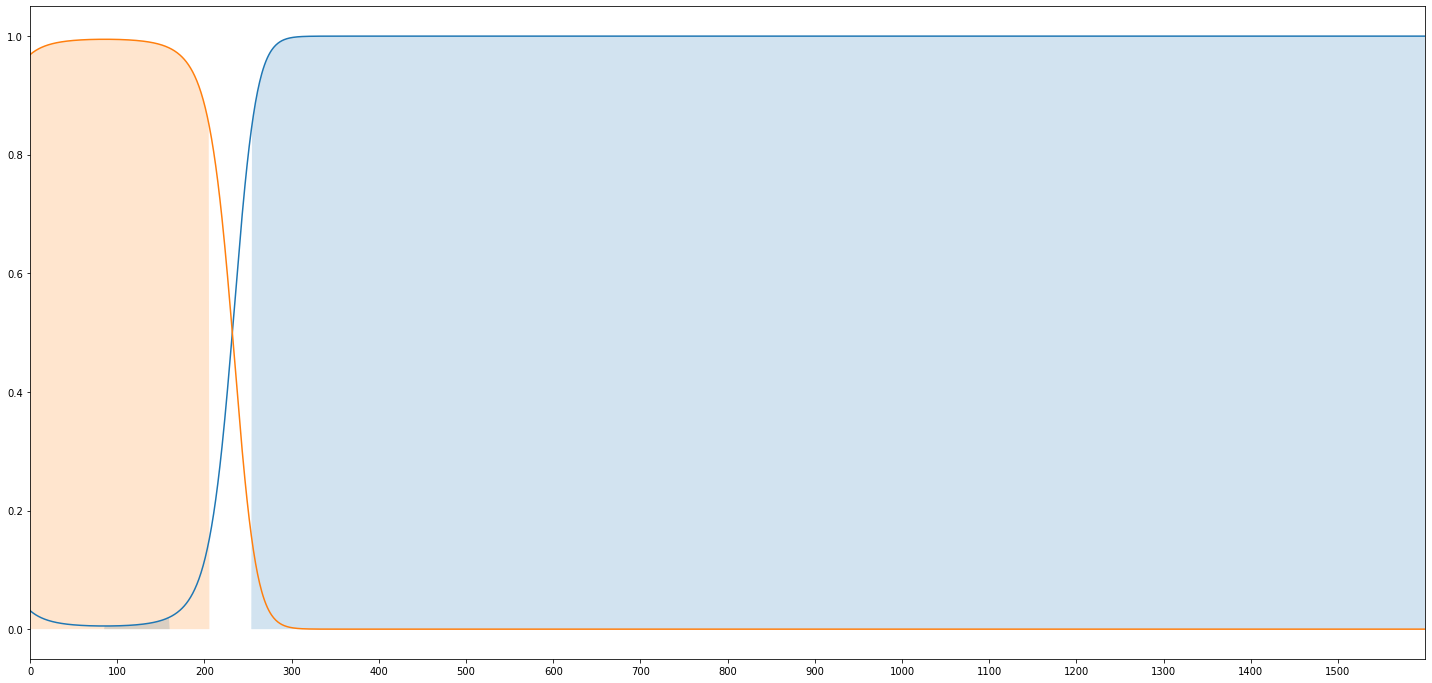

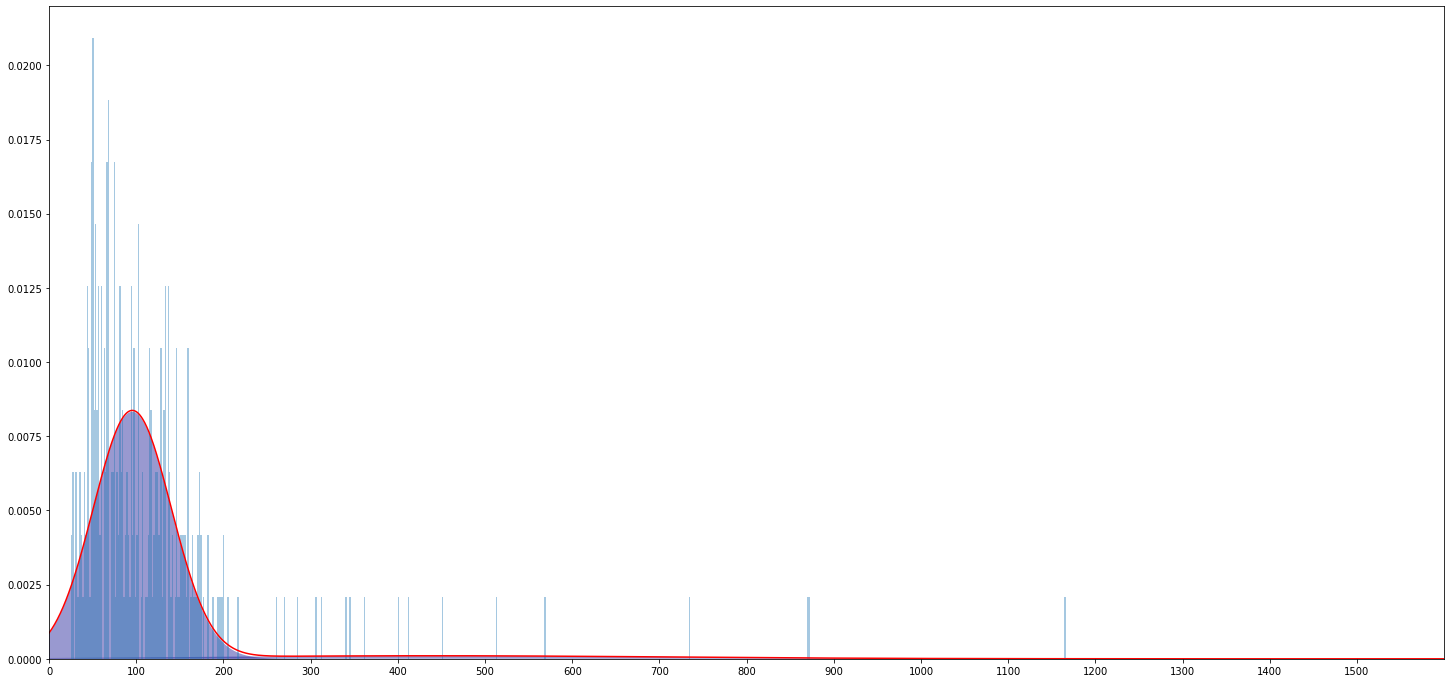

In [79]:
# 85 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 85].iki,2,1600)

90: 220.8
85: 227.99999999999997
85: 274.40000000000003
90: 280.0


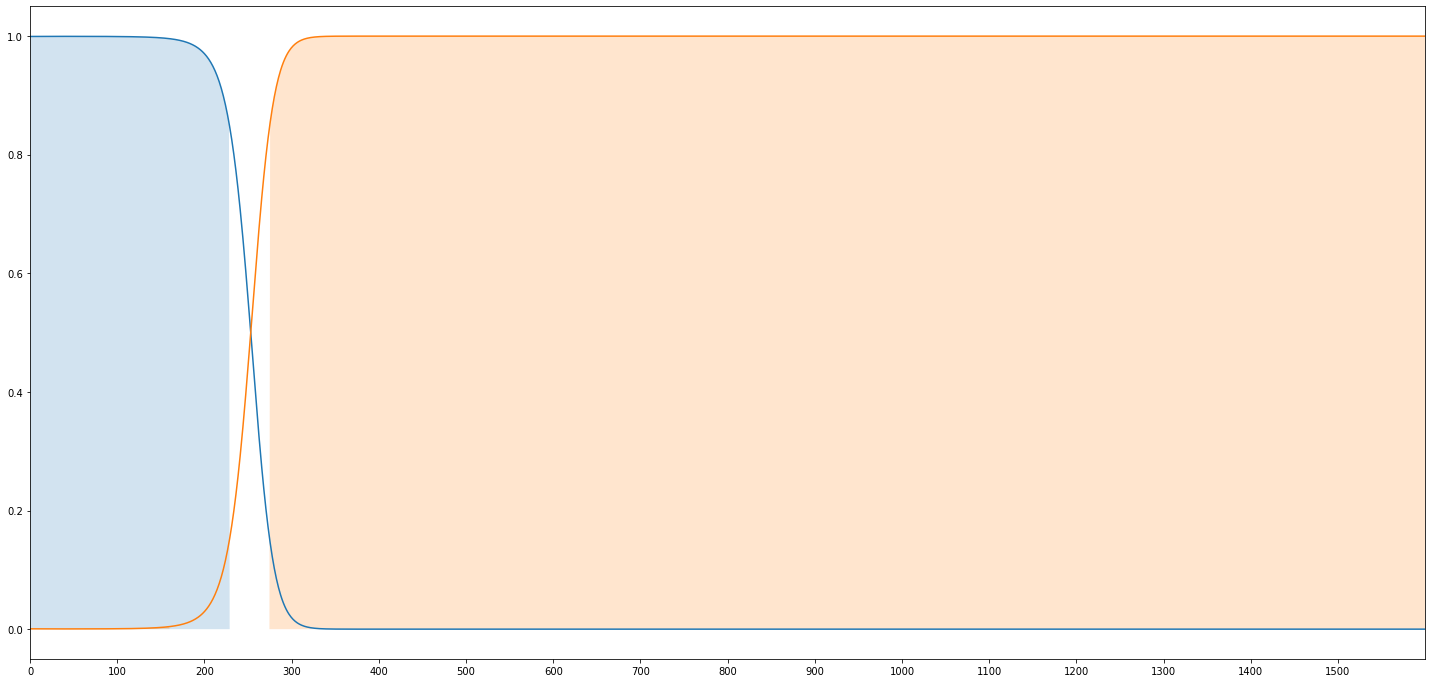

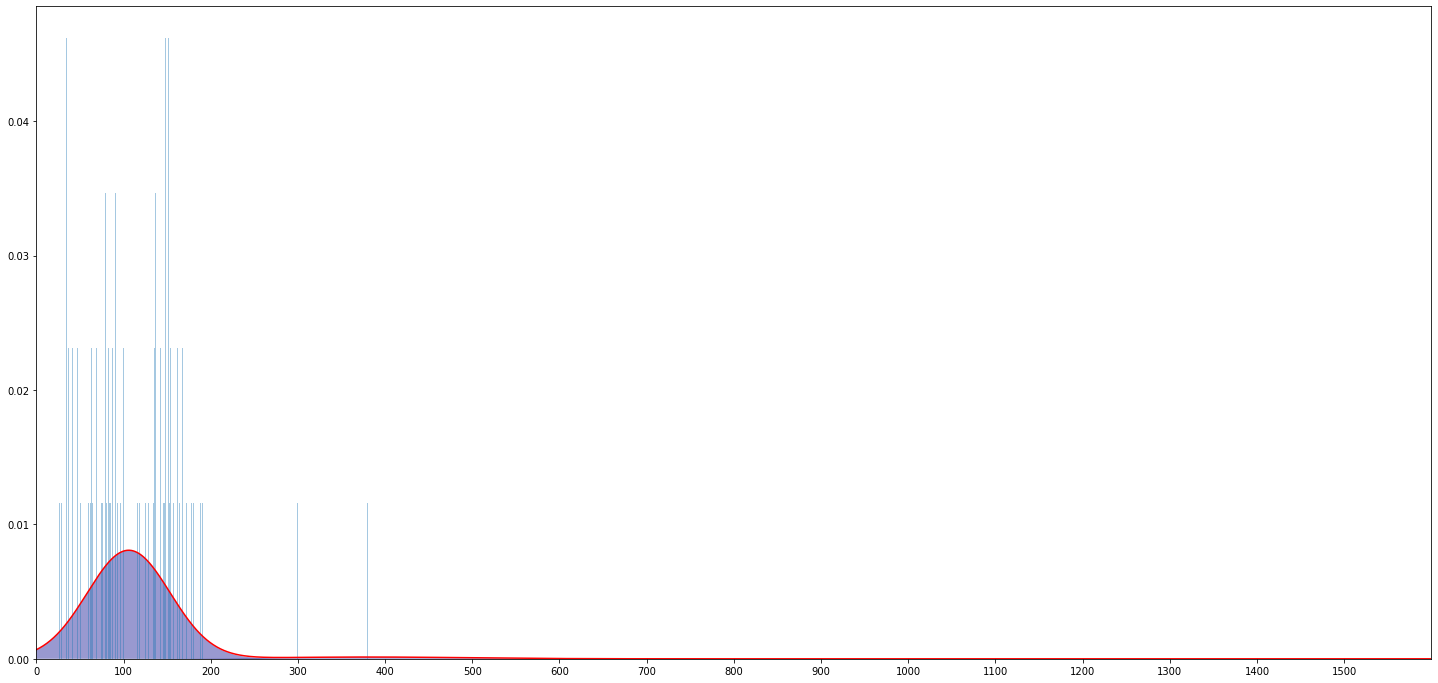

In [80]:
# 90 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 90].iki,2,1600)

90: 86.1
85: 91.0
85: 123.19999999999999
90: 127.39999999999999


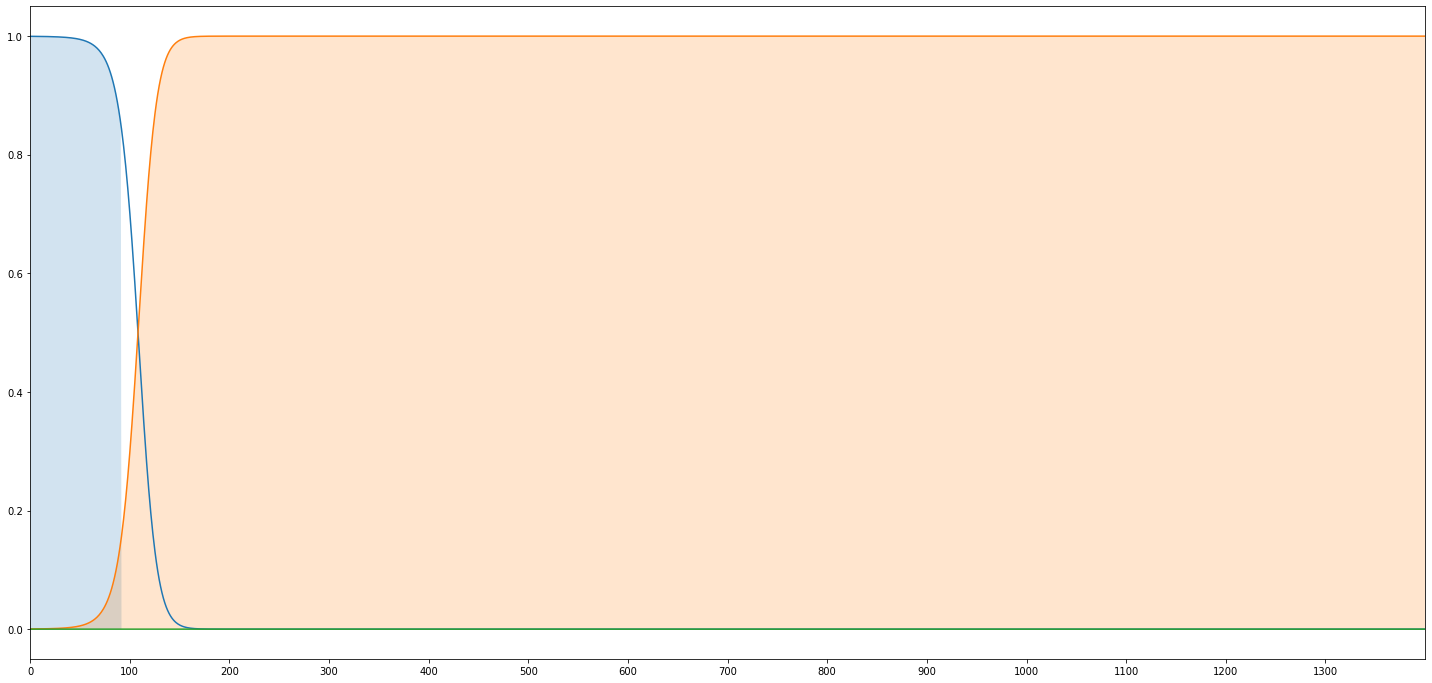

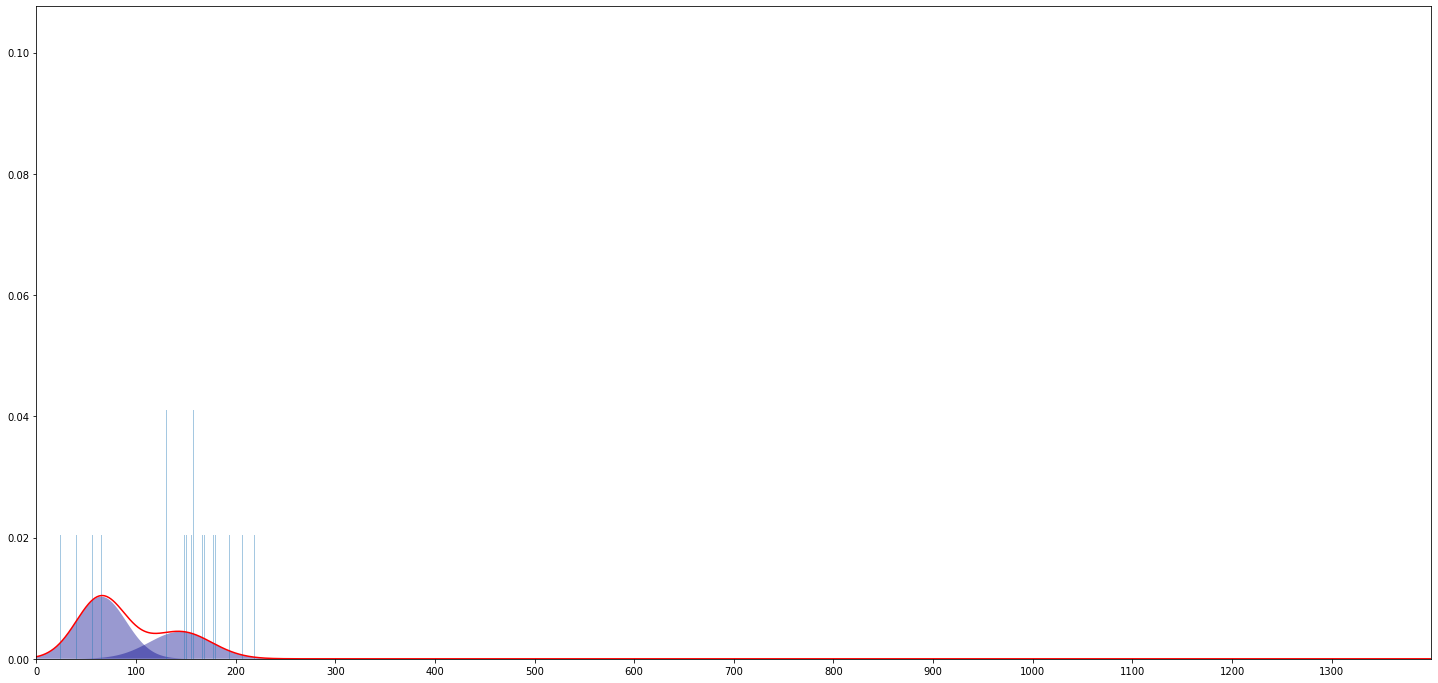

In [82]:
# 95 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 95].iki,3,1400)

85: 128.6
90: 128.7
85: 128.0
90: 128.0


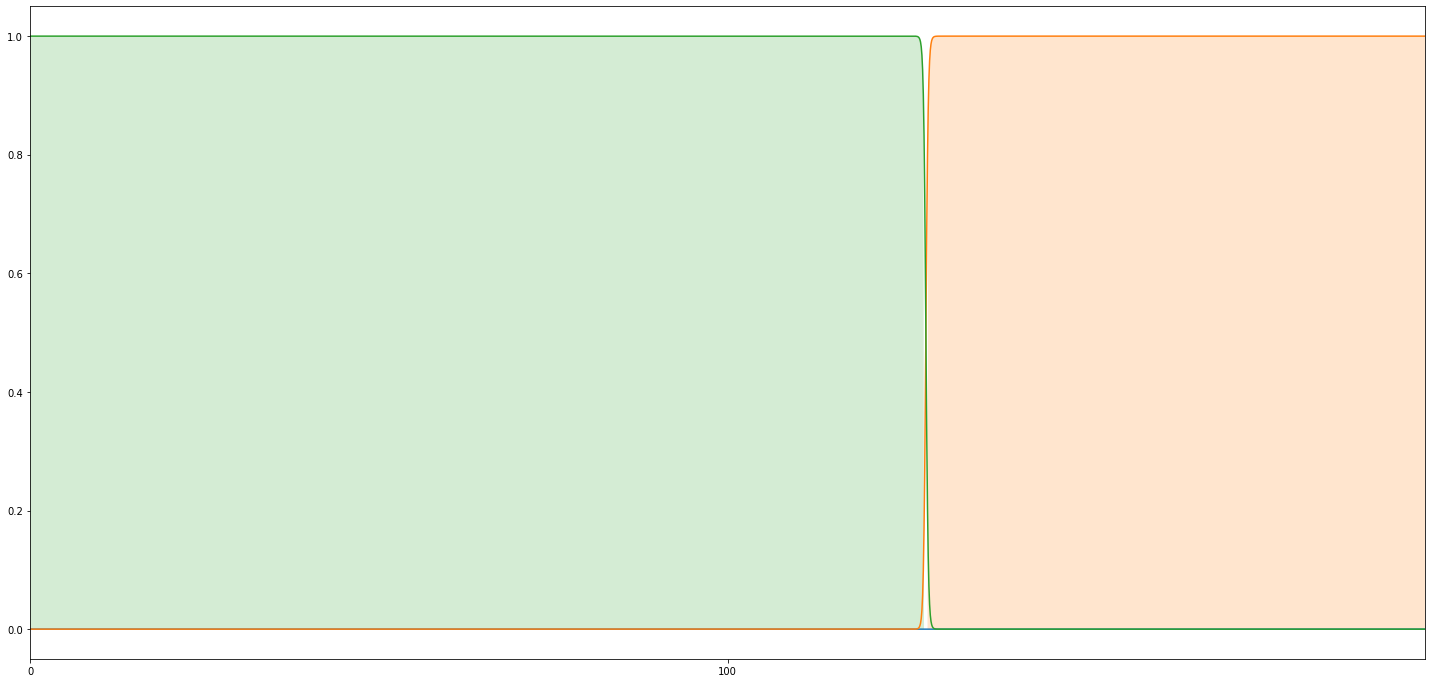

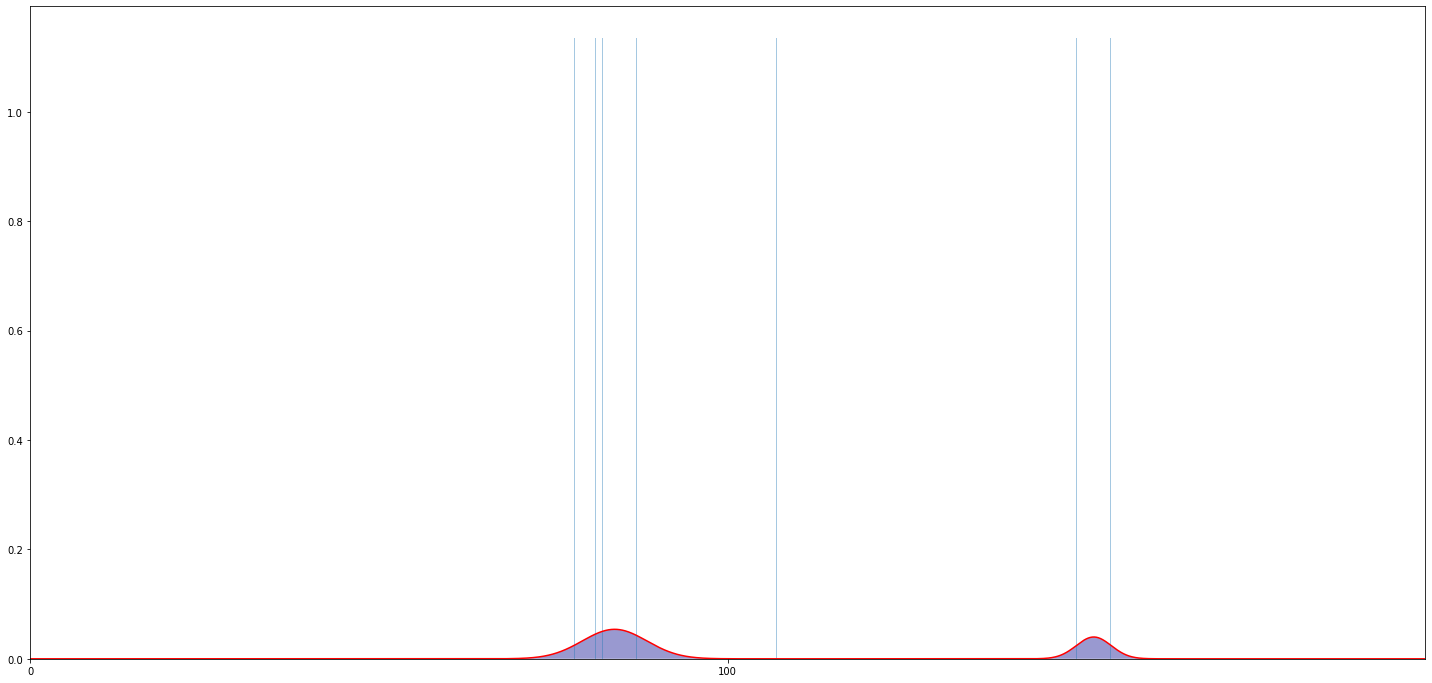

In [83]:
# 100 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 99].iki,3,1200)

In [78]:
# Classification strategy

user_group = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
thresholds = [800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,345,354,556,438,408,376,380,356,351,339,327,315,297,297,290,288,253,274,300,300,253,268,419,276,300,281,293,279,278,272,263,252,236,236,233,235,205,228,200,200]
threshold_types  = ['prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified', 'autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr']

df = pd.DataFrame(data=[user_group,thresholds,threshold_types])
df = df.T
df = df.rename(columns={0: "user_group", 1: "iki",2: "threshold_types"})

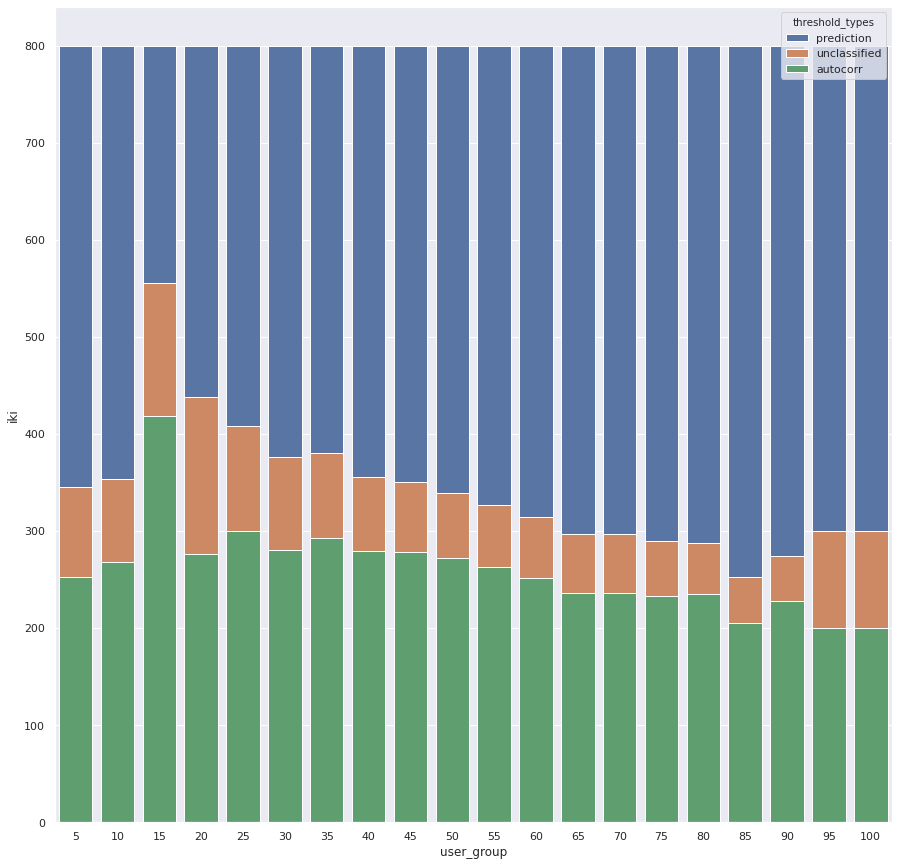

In [79]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,15)})
sns.barplot(x=df.user_group,y=df.iki,hue=df.threshold_types,data=df,dodge=False)

In [80]:
Analyze_user_group(log_comb_ite_with_participants_ites)

---------------------------------------------------------------------------------------------------------------
  User Group   | Sample Size  | % Autocorr    | % Predict     | % Undef.      | Threshold Min | Threshold Max  
---------------------------------------------------------------------------------------------------------------
  5 WPM        |          285 |        31.579 |        64.211 |          4.21 |           253 |           345  
  10 WPM       |          606 |        29.703 |        67.492 |         2.805 |           268 |           354  
  15 WPM       |         2369 |        24.441 |        70.494 |         5.065 |           419 |           556  
  20 WPM       |         5954 |        19.936 |        70.222 |         9.842 |           276 |           438  
  25 WPM       |        11406 |         36.27 |        58.399 |         5.331 |           300 |           408  
  30 WPM       |        16476 |        47.584 |        46.735 |         5.681 |           281 |         

In [1]:
Analyze_losses_with_old_thresholds(log_comb_ite_with_participants_ites)

NameError: name 'Analyze_losses_with_old_thresholds' is not defined

In [359]:
log_comb_ite_with_participants_ites.shape[0]

139022